**Prepared by: Tim Hayes**

**Cohort: AI-DL-JUL''23**'

# **Project Description:Twitter US Airline Sentiment**

# **Data Description**:

- A sentiment analysis job about the problems of each major U.S. airline. 
- Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


# **Dataset**:

- The project is from a dataset from Kaggle.
- Link to the Kaggle project site:https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- The dataset has to be downloaded from the above Kagglewebsite.
- The dataset has the following columns:

> - tweet_id 
> - airline_sentiment
> - airline_sentiment_confidence  
> - negativereason
> - negativereason_confidence
> - airline
> - airline_sentiment_gold
> - name
> - negativereason_gold
> - retweet_count
> - text
> - tweet_coord
> - tweet_created
> - tweet_location 
> - user_timezone

text is the independent variable and airline_sentiment is the target variable.

# **Objective**:

- To classify the sentiment of tweets into the positive, neutral & negative.

# **Learning Outcomes**:
- Text based EDA
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
    - Bag of words
    - Tf-idf
- Build the classification model.
- Tune & Evaluate the Model performance.
- Plot the  important features after training the model.

### Importing the necessary libraries

In [28]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
import random
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
import seaborn as sns                                   # Import seaborn
import matplotlib.pyplot as plt                         # Import Matplotlib

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from wordcloud import WordCloud,STOPWORDS               # Import WorldCloud and Stopwords
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import CountVectorizer # Import count Vectorizer
from sklearn.model_selection import train_test_split    # Import train test split
from sklearn.ensemble import RandomForestClassifier     # Import Rndom Forest Classifier
from sklearn.model_selection import cross_val_score     # Import cross val score
from sklearn.metrics import confusion_matrix            # Import confusion matrix
from wordcloud import WordCloud                         # Import Word Cloud
from sklearn.feature_extraction.text import TfidfVectorizer # Import Tf-Idf vector
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.preprocessing import LabelEncoder

import nltk
import warnings
warnings.simplefilter("ignore")
nltk.download('omw-1.4')

# Helped to create train and test data
from sklearn.model_selection import train_test_split

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Used to create the Sequential model
from keras.models import Sequential
import tensorflow as tf
# Used to create the tokens from the text data
from tensorflow.keras.preprocessing.text import Tokenizer

# Helps to pad the sequences into the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
# Layers that are used to implement the LSTM model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras import regularizers, backend
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import RandomizedSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)
from abc import ABC, abstractmethod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thayes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thayes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thayes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thayes\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# Seed for reproducibility
seed = 42

In [30]:
# Don't truncate text columns
pd.set_option('display.max_colwidth', None)

## Useful Utility Functions

In [31]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

## Useful graphical functions

In [32]:
def output_pretty_countplot(df, x, order=None, hue=None, figsize=None, title=None, palette=None):
    '''Output a customized nice looking standardized countplot
        df: DataFrame to use
        x: The x axis variable to use in the plot
        order: Ordering of the bar counts
        hue: The hue variable to use in the plot default is None
        figsize: The figure size tuple to use in the plot default is None
        title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot: for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,3.5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue, palette=palette);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();

def output_wordcloud(data, title, sentiment=None, top_features=None):
    '''Output a wordcloud
        data: dataframe
        title: Title of wordcloud
        sentriment: Optional sentiment default is None
        top_features: Optional top features to output default is None
    '''
    # If we have a sentiemnt filter the reviews
    if (sentiment is not None):
        reviews = data[data['airline_sentiment'] == sentiment]['text']
        words = ' '.join(reviews)
        words = ' '.join(word for word in words.split())
    else:
        words = top_features

    # Wordcloud's algorithm was finding 't', 'co' and 't co' as a word. Add this the stopwords list so its excluded.
    custom_stopwords = STOPWORDS.union(('t co', 't', 'co'))
    wordcloud = WordCloud(stopwords = custom_stopwords,
                          colormap = 'RdBu',
                          background_color = 'black',
                          width = 2000,
                          height = 1500
                         ).generate(words)
    plt.figure(1, figsize = (8, 8), frameon='equal')
    plt.title(title, fontsize=20)

    # Using the .imshow() method of matplotlib.pyplot to display the Word Cloud as an image.
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def plot_loss_accuracy(model_name, history):
    '''Output loss and accuracy curve
        model_name: Name of the model
        history: History results from fit
    '''
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy for {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();

    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss for {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();

def make_classification_report(y, y_pred, categories, title_suffix='Test'):
    ''' Build classification report
        y: Base truth
        y_pred: Predictions
        categories: Classes
        title_suffix: Suffix to append to title
    '''
    cr = classification_report(y, y_pred, output_dict=True, target_names=categories)
    df_classification = pd.DataFrame(cr).transpose()

    # Add a nice title to the classification report
    df_classification = df_classification.style.set_caption('Classification report for {}'.format(title_suffix))\
                                                 .set_table_styles([{
                                                     'selector': 'caption',
                                                     'props': 'text-align: center;font-size: 1.5em;font-weight:bold;'
                                                 }], overwrite=False)
    display(df_classification)

def make_confusion_matrix(y_max, y_pred, categories, figsize=None,title=None):
    ''' This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
        y: Base truth
        y_pred: Predictions
        categories: Classes
        figsize: Default to None
        title: Default to None
    '''
    # Create confusion matrix
    cf = confusion_matrix(y_max, y_pred)

    # Metrics
    accuracy  = accuracy_score(y_max, y_pred)
    precision = precision_score(y_max, y_pred, average='weighted')
    recall    = recall_score(y_max, y_pred, average='weighted')
    f1        = f1_score(y_max, y_pred, average='weighted')

    stats_text = stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                        accuracy,precision,recall,f1)

    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    plt.figure(figsize=figsize)

    # Confusion matrix normalized per category true value
    cf_norm = cf/np.sum(cf, axis=1)
    sns.heatmap(cf_norm, xticklabels=categories, yticklabels=categories, annot=True)

    plt.xlabel(stats_text)

    if title:
        plt.title('Confusion matrix for {}'.format(title))

    plt.show();

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": accuracy, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

def output_results(model, x, y, categories, figsize=None,title=None, binarized=False):
    ''' This function will make a pretty plot of an sklearn Confusion Matrix and a Classification report
        model: Model to use
        x: Dependent variable
        y: Indepdendent variable
        figsize: Default to None
        title: Default to None
        binarized: Has the target variable been binarized, default is False
    '''

    ## Lets make predictions to generate a confusion matrix
    predictions = model.predict(x)

    # If we have a binarized target variable we can't use predictions straight up and must employ np.argmax
    if (binarized):
        # Obtaining the categorical values from y_test_encoded and y_pred
        y_pred = np.argmax(predictions,axis=1)
        y_max = np.argmax(y, axis=1)
    else:
        y_pred = predictions
        y_max = y

    df_perf = make_confusion_matrix(y_max, y_pred, categories, figsize, title)

    make_classification_report(y_max, y_pred, categories, title)

    return df_perf, y_pred

def output_misclassification(title, estimator_range, misclassification_error, optimal_num_estimators):
    ''' This function output the misclassification error vs the number of estimators
        title: Title of plot
        estimator_range: Range for n_estimators
        misclassification_errors: Error array
        optimal_num_estimators: Optimal number of estimators.
    ''' 
    plt.title(title)
    plt.plot(estimator_range, misclassification_error, marker='o', linestyle='-')
    xy = (optimal_num_estimators, min(misclassification_error))
    formatted_xy = ("(%.3f, %.3f)" % xy)  # Format xy to three decimal places

    # Create a dictionary for text properties (bold and red color)
    text_properties = {'weight': 'bold', 'color': 'red', 'fontsize': 9}

    plt.title(title)

    # Annotate the plot with the formatted text
    plt.annotate(formatted_xy, xy=xy, textcoords='data', **text_properties)

    plt.xlabel("Number of estimators")
    plt.ylabel('Misclassification Error')
    plt.grid(True)
    plt.show()

## Useful Text Processing class

In [33]:
class TextProcessor(object):
    def __init__(self, custom_list=None):
        self.lemmatizer = WordNetLemmatizer()
        self.custom_list = custom_list or []
        self.stopwords = stopwords.words('english')
        self.stopwords = list(set(self.stopwords) - set(self.custom_list))

    def remove_html_tags(self, text):
        ''' Remove HTML tags from text.
            text: Text to process
        '''
        try:
            text = BeautifulSoup(text, 'html.parser').get_text()

        except Exception as e:
            print(f"Error in remove_html_tags: {e}")

        return text

    def replace_contractions(self, text):
        ''' Remove contractions from text.
            text: Text to process
        '''
        try:
            text = contractions.fix(text)

        except Exception as e:
            print(f"Error in replace_contractions: {e}")

        return text

    def remove_extra_spaces(self, text):
        ''' Remove extra spaces from a string.
            text: Text to process
        '''
        try:
            text = re.sub(r'\s+', ' ', text)

        except Exception as e:
            print(f"Error in remove_extra_spaces: {e}")

        return text

    def remove_urls(self, text):
        ''' Remove urls from a string.
            text: Text to process
        '''
        try:
            text = re.sub(r'http\S+', '', text)

        except Exception as e:
            print(f"Error in remove_urls: {e}")

        return text

    def remove_numbers(self, text):
        ''' Remove all numbers from a string.
            text: Text to process
        '''
        try:
            text = re.sub(r'\d+', '', text)

        except Exception as e:
            print(f"Error in remove_numbers: {e}")

        return text

    def remove_non_ascii(self, word):
        ''' Remove non-ASCII characters from a word.
            word: Word to process
        '''
        try:
            word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        except Exception as e:
            print(f"Error in remove_non_ascii: {e}")

        return word

    def to_lowercase(self, word):
        ''' Convert a word to lowercase.
            word: Word to process
        '''
        try:
            word = word.lower()

        except Exception as e:
            print(f"Error in to_lowercase: {e}")

        return word

    def remove_punctuation(self, word):
        ''' Remove punctuation from a word.
            word: Word to process
        '''
        try:
            word = re.sub(r'[^\w\s]', '', word)
        except Exception as e:
            print(f"Error in remove_punctuation: {e}")

        return word

    def remove_stopwords(self, word):
        ''' Remove stop words from a word.
            word: Word to process
        '''
        try:
            word = word if word not in self.stopwords else ''

        except Exception as e:
            print(f"Error in remove_stopwords: {e}")

        return word


    def lemmatize_list(self, word):
        ''' Lemmatize a word to reduce it to its base form.
            word: Word to process
        '''
        try:
            word = self.lemmatizer.lemmatize(word, pos='v')

        except Exception as e:
            print(f"Error in lemmatize_list: {e}")

        return word

    def process_text(self, text):
        ''' Process a block of text.
            text: Text to process
        '''
        try:
            text = self.remove_html_tags(text)
            text = self.replace_contractions(text)
            text = self.remove_numbers(text)
            text = self.remove_extra_spaces(text)
            text = self.remove_urls(text)

        except Exception as e:
            print(f"Error in process_text: {e}")

        return text

    def process_words(self, words):
        ''' Process a list of words.
            words: Words to process (list)
        '''
        new_words = []
        for word in words:
            word = self.remove_non_ascii(word)
            word = self.to_lowercase(word)
            word = self.remove_punctuation(word)
            word = self.remove_stopwords(word)
            word = self.lemmatize_list(word)

            # Don't add if it's the empty string
            if word != '':
                new_words.append(word)

        return ' '.join(new_words)

    def process(self, series):
        ''' Process a Series (column) from a DataFrame.
            series: Series to process
        '''
        series_processed = None

        try:
            # Clean up the text in the series
            series_processed = series.apply(self.process_text)

            # Tokenize the text in the series
            series_processed = series_processed.apply(lambda text: nltk.word_tokenize(text))

            # Process the words and apply the cleaning steps in the series
            series_processed = series_processed.apply(self.process_words)

        except Exception as e:
            print(f"Error in process: {e}")

        return series_processed

## Useful modeling classes

In [34]:
class BaseRandomForestModel(object):
    def __init__(self, model_name, x_train, y_train, x_test, y_test, categories, estimator_range=[100, 150, 200, 250, 300, 350]):
        self.model_name = model_name
        self.categories = categories
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.test_results = None
        self.y_pred_testing = None
        self.training_resuls = None
        self.y_pred_training = None
        self.estimator_range = estimator_range
        set_seed(seed)
        self.create_model()

    # Abstract method that must be implemented by child classes
    @abstractmethod
    def get_best_parameters(self):
        pass
      
    def create_model(self):
        ''' Create a random forest model based on optimal parms
        '''
        optimal_params = self.get_best_parameters()
        self.model = RandomForestClassifier(**optimal_params, n_jobs=5, random_state=seed)
        display(self.model.fit(self.x_train, self.y_train))

    def build_model(self):
        ''' Build, fit and evaluate the model performance
        '''
        # Go ahead and fit the model
        self.model.fit(self.x_train, self.y_train)

        # Output results for validation and test and save predictions
        self.training_results, self.y_pred_training = output_results(self.model, self.x_train, self.y_train, self.categories, 
                                                                     title='Training for {}'.format(self.model_name), figsize=(8, 5))

        self.test_results, self.y_pred_test = output_results(self.model, self.x_test, self.y_test, self.categories, 
                                                             title='Test for {}'.format(self.model_name), figsize=(8, 5))
    
class BasicRandomForest(BaseRandomForestModel):
    def __init__(self, *args):
        super(BasicRandomForest, self).__init__(*args)
    
    def get_best_parameters(self):
        ''' Get the best parameters via cross val score
        '''
        errors = []
        cv = 5
        for estimators in self.estimator_range:
            clf = RandomForestClassifier(n_estimators=estimators, random_state=seed)
            scores = cross_val_score(clf, self.x_train, self.y_train, cv=cv, scoring='accuracy')
            errors.append(1- scores.mean())

        # Find the optimal number of base learners
        optimal_estimators = self.estimator_range[errors.index(min(errors))]

        # Create a dictionary with the optimal parameters
        optimal_params = {'n_estimators': optimal_estimators}

        output_misclassification('{} misclassification vs estimators'.format(self.model_name), self.estimator_range, 
                                 errors, optimal_estimators)
    
        return optimal_params
    
class OptimizedRandomForest(BaseRandomForestModel):
    def __init__(self, *args):
        super(OptimizedRandomForest, self).__init__(*args)
    
    def get_best_parameters(self):
        ''' Get the best paramters via RandomizedSearch
        '''
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
        class_weight_dict = dict(enumerate(class_weights))
        cv = 5
        n_iter = 25

        # Setup the parameters to optimize
        param_grid = {
            "n_estimators": self.estimator_range,
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_depth": np.arange(3, 32, 2),
            "class_weight": [class_weight_dict],
            "min_impurity_decrease": [0.001, 0.002, 0.003]}
        
        # Create a RandomForestClassifier instance
        rf_classifier = RandomForestClassifier(random_state=seed)

        # Initialize StratifiedKFold
        stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=n_iter, cv=stratified_cv, 
                                           random_state=seed, n_jobs=-1)

        # Perform the random search on the training data
        random_search.fit(self.x_train, self.y_train)

        # Print the best hyperparameters found
        print("Best Hyperparameters:", random_search.best_params_)

        estimator_range = random_search.cv_results_['param_n_estimators']
        misclassification_error = 1 - random_search.cv_results_['mean_test_score']

        output_misclassification('{} misclassification vs estimators'.format(self.model_name), estimator_range, misclassification_error, 
                                 random_search.best_params_['n_estimators'])
        
        return random_search.best_params_

## Useful modeling functions

In [35]:
def get_top_features(model, all_features, number_of_top_features=20):
    ''' Find the top features for a model
        model: The model
        all_features: List of all features
        number_of_top_features: Default of 20
    '''
    top_features = []
    feats = model.feature_importances_
    features = np.argsort(feats)[::-1]

    for i in features[0:number_of_top_features]:
        top_features.append(all_features[i])

    return ' '.join(top_features)

def get_callbacks(model_name, early_stopping_patience=5):
    ''' Generate checkpoint, reduce learning rate and early stopping callbacks
        model_name: Name of the model
        early_stopping_patience: Default to 5
    '''
    checkpointer = ModelCheckpoint(filepath='airline_{}'.format(model_name),
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                      factor = 0.1,
                                      patience = 2,
                                      min_lr=0.000001,
                                      verbose = 1)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stopping_patience, mode='max', verbose=1)

    return [checkpointer,reduce_lr, early_stopping]

def get_performance_results(results, dataset_name):
    ''' Generate model performance dataframes
        results: Performance resutls
        dataset_name: Name of performance dataset
    '''
    # Performance comparison
    models_comp_df = pd.concat(
        list(results.values()),
        axis=1,
    )
    models_comp_df.columns = list(results.keys())
    models_comp_df = models_comp_df.style.set_caption('{} performance comparison'.format(dataset_name))\
                                                     .set_table_styles([{
                                                         'selector': 'caption',
                                                         'props': 'text-align: center;font-size: 1.5em;font-weight:bold;'
                                                     }], overwrite=False)
    return models_comp_df

## Load the analyze dataset

In [36]:
#If you are running from colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  # Load the dataset
  data = pd.read_csv('drive/MyDrive/Tweets.csv')
else:
  # Load the dataset
  data = pd.read_csv('Tweets.csv')

### Reading the dataset

### Checking the shape of the dataset

In [37]:
data.shape

(14640, 15)

#### Observations
- The dataset has 14640 rows of data with 15 columns.

### Displaying the first few rows of the dataset

In [38]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Observations
- tweet_id appears to be a unique index.
- negative_reason_confidence, airline_sentiment_gold, negative_reason, negative_reason_confidence, negative_reason_gold, tweet_coord and tweet_location have null values.

### Get datatype info about the dataset

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

#### Observations
- There are two float columns, two int columns and eleven object columns.

### Let's get a statistical summary of the data

In [40]:
# Use describe() to get a numerical statistical summary
columns_to_show = ['airline_sentiment_confidence', 'negativereason_confidence', 'retweet_count']
describe_result = data[columns_to_show].describe().T.apply(lambda x: x.apply(lambda y: format(y, '.2f')))
display(describe_result)

,count,mean,std,min,25%,50%,75%,max
airline_sentiment_confidence,14640.00,0.90,0.16,0.34,0.69,1.00,1.00,1.00
negativereason_confidence,10522.00,0.64,0.33,0.00,0.36,0.67,1.00,1.00
retweet_count,14640.00,0.08,0.75,0.00,0.00,0.00,0.00,44.00


#### Observations
- The min for airline_sentiment_confidence is .34 while the mean is .90 which less than the median indicating the data is left skewed.
- The min for negative_reason_confidence is 0 while the mean is .64 which less than the median indicating the data is left skewed.
- The min for retweet_count is 0 while the mean is .08 which great than the median indicating the data is right skewed.

In [41]:
# Use describe() to get a statistical summary
data.describe(include=object).T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


#### Observations
- The most common airline_sentiment is negative with 9178 responses or 62.6% of the total non-null responses.
- The most common negative_reason is Customer Service Issue with 2910 responses or 31.7% of the total non-null responses.
- The most common airline is United 3822 responses or 26.1% of the total non-null responses.
- The most common airline_sentiment_gold is negative with 32 responses or 80% of the total non-null responses.
- The most common name is JetBlueNews with 63 responses or .4% of the total non-null responses.
- The most common negative_reason_gold is Customer Service Issue with 32 responses or 37.5% of the total non-null responses.
- The most common text is @united thanks with 6 responses or .04% of the total non-null responses.
- The most common tweet_coord is [0.0, 0.0] with 164 responses or 16% of the total non-null responses.
- The most common tweet created is 2015-02-24 09:54:34 -0800 with 5 responses or 0.3% of the total non-null responses.
- The most common tweet location is Boston with 157 responses or 1.5% of the total non-null responses.
- The most common user_timezone is Eastern Time with 3744 responses or 38.12% of the total non-null responses.

In [42]:
# Find the min and max tweet dates
dates = pd.to_datetime(data['tweet_created'])
print('Min Date {}, Max Date {}'.format(dates.min(), dates.max()))

Min Date 2015-02-16 23:36:05-08:00, Max Date 2015-02-24 11:53:37-08:00


#### Observations
- The date range of our dataset is almost 8 days.

### Checking for missing values

In [43]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

#### Observations
- We do have null values in negativereason, negativereason_confidence, airline_sentiment_gold,negativereason_gold, tweet_coord, tweet_location and user_timezone.
- For the purposes of this analysis we only care about airline_sentiment and text both of which do not have null values thus we will not be imputing the null values.

### Checking for duplicates

In [44]:
data.duplicated().sum()

36

In [45]:
data[(data.negativereason.isnull() == False) & (data.negativereason_gold.isnull() == False)]\
    .duplicated().sum()

0

#### Observations
- The dataset has duplicates but these are due to null columns.
- If we do not consider the null rows for negativereasons and negative_reasons_gold there are no duplicates.

### <b>EDA


- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

- What is the percentage of tweets for each airline?
- What is the distribution of sentiments across all the tweets?
- What is the distribution of sentiments for each airline?
- What does the plot of negative reasons indicate?
- How does a wordcloud appear for negative tweets?
- How does a wordcloud appear for positive tweets?
- What are insights observed from EDA?

### <b>Univariate Analysis

### Let's investigate airline_sentiment

*What is the distribution of sentiments across all the tweets?*

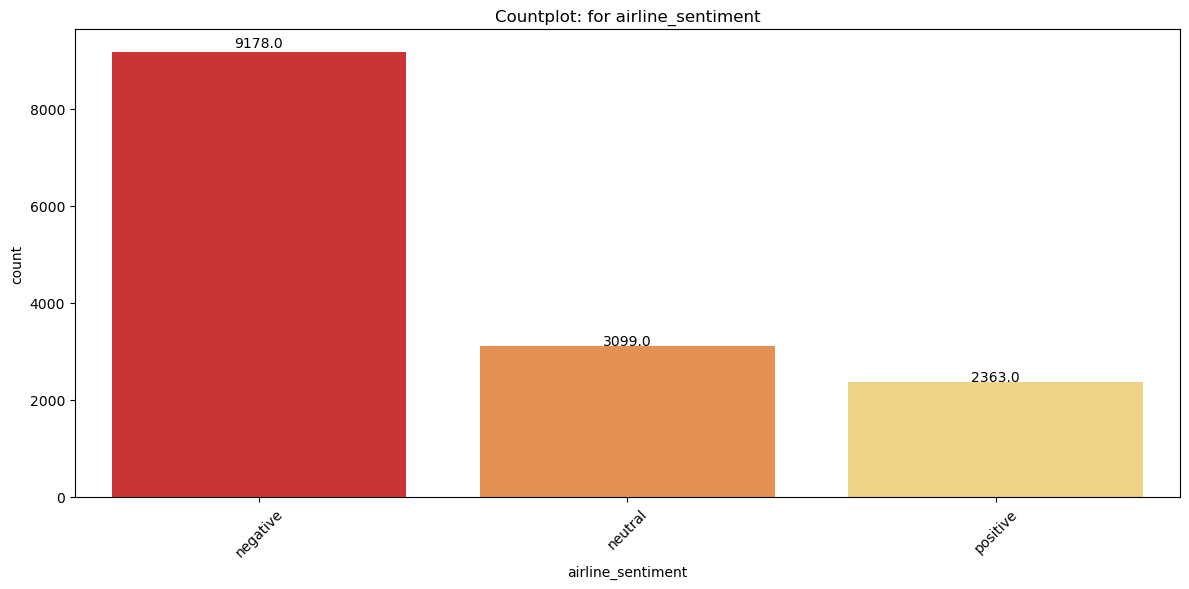

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [46]:
# Output a countplot of the airline_sentiment variable
output_pretty_countplot(data, 'airline_sentiment', order=data['airline_sentiment'].value_counts().index,
                       palette='YlOrRd_r', figsize=(12,6))
data['airline_sentiment'].value_counts(normalize=True)

#### Observations
- 62.6% of the sentiment is negative while only 16.1% is positive.
- From the plot we can see the target variable is imbalanced the negative sentiment is 2.96 times the neutral sentiment and 3.88 times the positive sentiment.

### Let's investigate airline

*What is the percentage of tweets for each airline?*

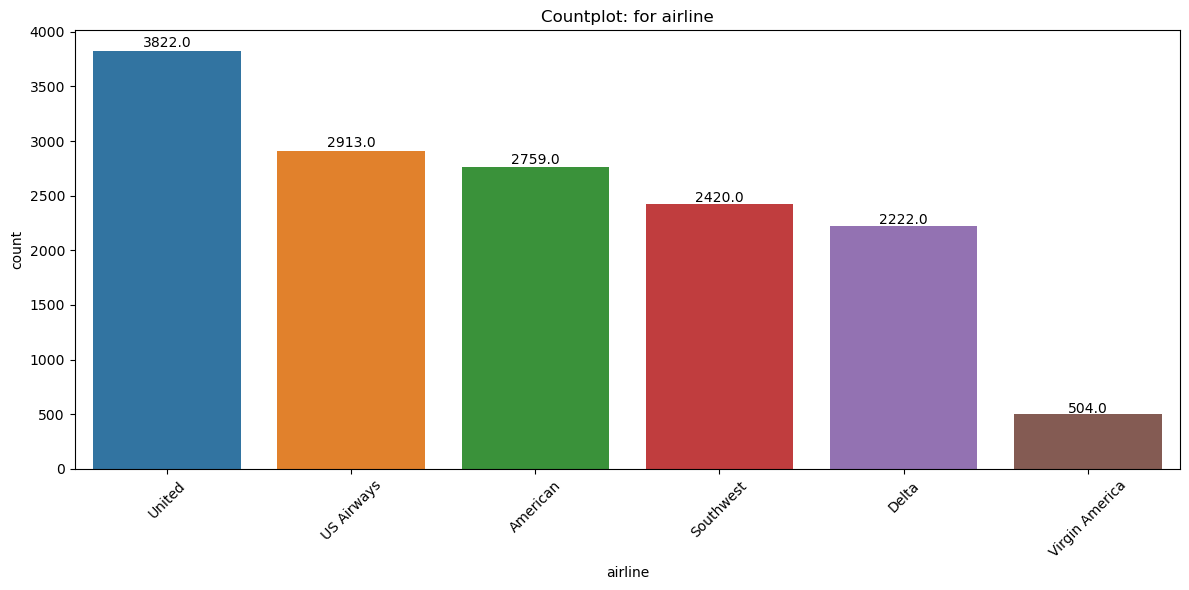

United            0.261066
US Airways        0.198975
American          0.188456
Southwest         0.165301
Delta             0.151776
Virgin America    0.034426
Name: airline, dtype: float64

In [47]:
# Output a countplot of the airline variable
output_pretty_countplot(data, 'airline', order=data['airline'].value_counts().index, figsize=(12,6))
data['airline'].value_counts(normalize=True)

#### Observations
- The top three airlines for tweets are United, US Airways and American with 26.1%, 19.8% and 18.8% respectively. These top three airlines make up 64.7 of the total tweets.
- The airliine with the fewest tweets was Virigin American with 3.4% of the tweets


### Let's investigate negativereason

*What does the plot of negative reasons indicate?*

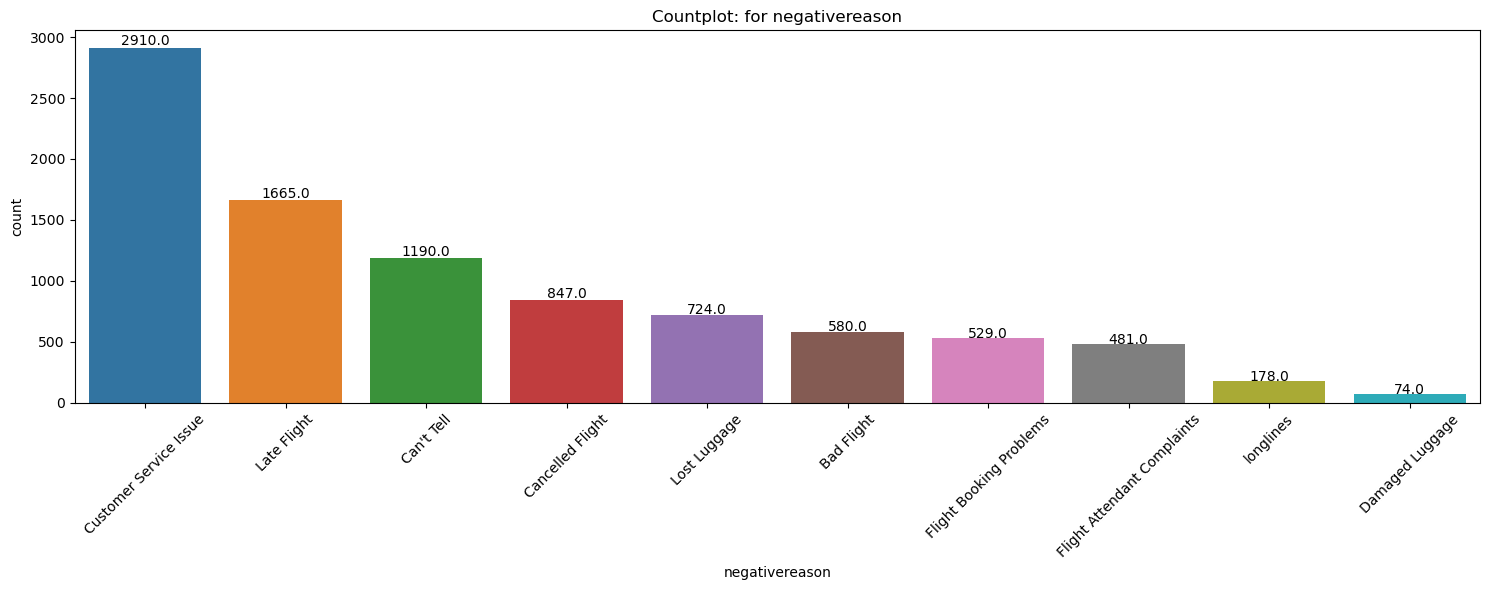

Customer Service Issue         0.317063
Late Flight                    0.181412
Can't Tell                     0.129658
Cancelled Flight               0.092286
Lost Luggage                   0.078884
Bad Flight                     0.063195
Flight Booking Problems        0.057638
Flight Attendant Complaints    0.052408
longlines                      0.019394
Damaged Luggage                0.008063
Name: negativereason, dtype: float64

In [48]:
# Output a countplot of the negativereason
output_pretty_countplot(data, 'negativereason',
                        order=data['negativereason'].value_counts().index, figsize=(15,6))
data['negativereason'].value_counts(normalize=True)

#### Observations
- The top negative reason was Customer Service issue with 31.7% of the tweets. If Customer Service Issue and reason Late Flight are combined they make up over 49% of the negative reasons.
- The negative reason that occurred least frequently is Damaged Luggage with .8% of the negative reasons.

- What is interesting is that customer service issues which are the biggest source for negative sentiment are controllable by the airlines unlike late flights due to weather or airport traffic issues.

### Let's investigate negativereason_gold

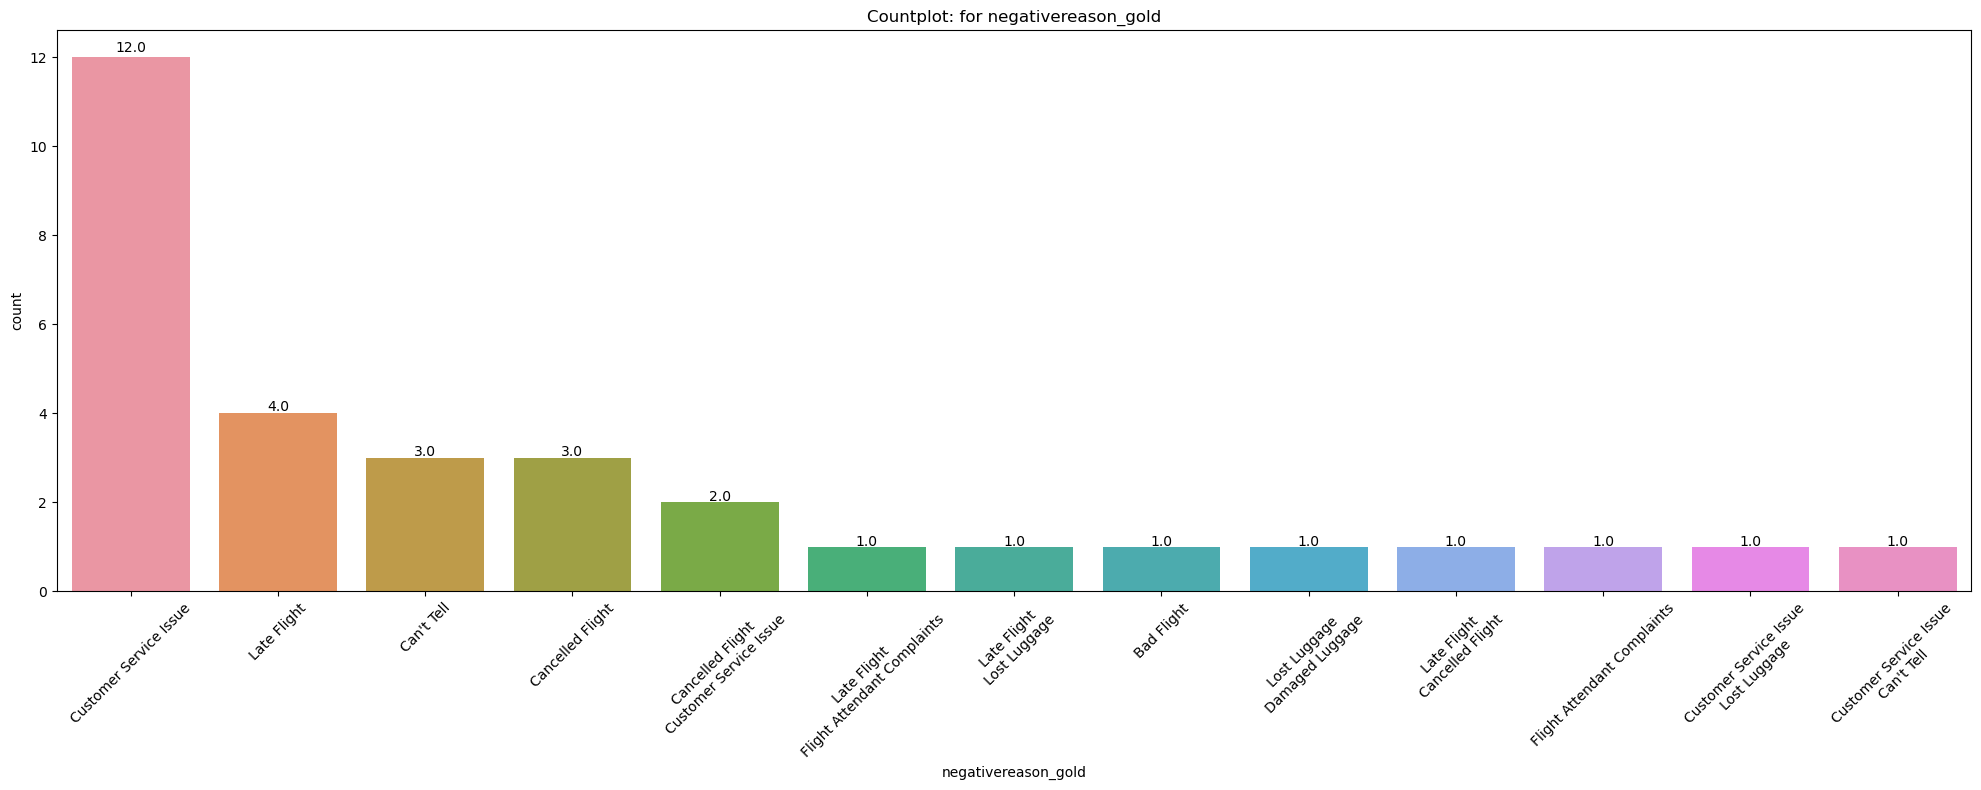

Customer Service Issue                      0.37500
Late Flight                                 0.12500
Can't Tell                                  0.09375
Cancelled Flight                            0.09375
Cancelled Flight\nCustomer Service Issue    0.06250
Late Flight\nFlight Attendant Complaints    0.03125
Late Flight\nLost Luggage                   0.03125
Bad Flight                                  0.03125
Lost Luggage\nDamaged Luggage               0.03125
Late Flight\nCancelled Flight               0.03125
Flight Attendant Complaints                 0.03125
Customer Service Issue\nLost Luggage        0.03125
Customer Service Issue\nCan't Tell          0.03125
Name: negativereason_gold, dtype: float64

In [49]:
# Output a countplot of the negativereason_gold
output_pretty_countplot(data, 'negativereason_gold',
                        order=data['negativereason_gold'].value_counts().index, figsize=(20,8))
data['negativereason_gold'].value_counts(normalize=True)

#### Observations
- Although there are a very low numbers of responses for negativereason_gold the top negative reason was Customer Service issue with 37.5% of the tweets which is quite close the distribution for negativereason.
- The second most common response for negativereason_gold is Late Flight which also mirrors the negativereason distribution.

### Let's investigate tweet_location

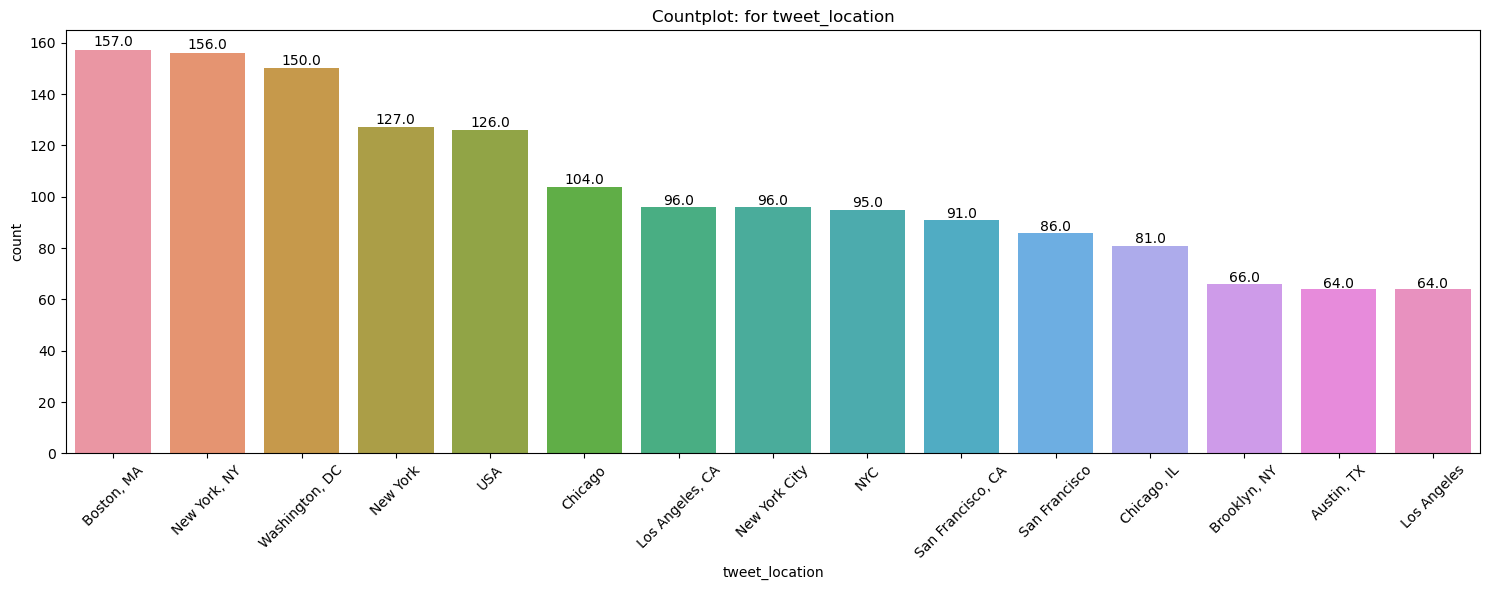

Boston, MA           0.015847
New York, NY         0.015746
Washington, DC       0.015141
New York             0.012819
USA                  0.012718
Chicago              0.010498
Los Angeles, CA      0.009690
New York City        0.009690
NYC                  0.009589
San Francisco, CA    0.009185
San Francisco        0.008681
Chicago, IL          0.008176
Brooklyn, NY         0.006662
Austin, TX           0.006460
Los Angeles          0.006460
Name: tweet_location, dtype: float64

In [50]:
top_locations = data['tweet_location'].value_counts().head(15).index.tolist()
# Output a countplot of the tweet_location
output_pretty_countplot(data[data['tweet_location'].isin(top_locations)], 'tweet_location',
                        order=data['tweet_location'].value_counts().head(15).index, figsize=(15,6))
data['tweet_location'].value_counts(normalize=True).head(15)

#### Observations
- Of the top fifteen location the top three tweet locations are Boston, New York and Washington DC which make up over 4.5% of the tweets.

### Let's investigate user_timezone

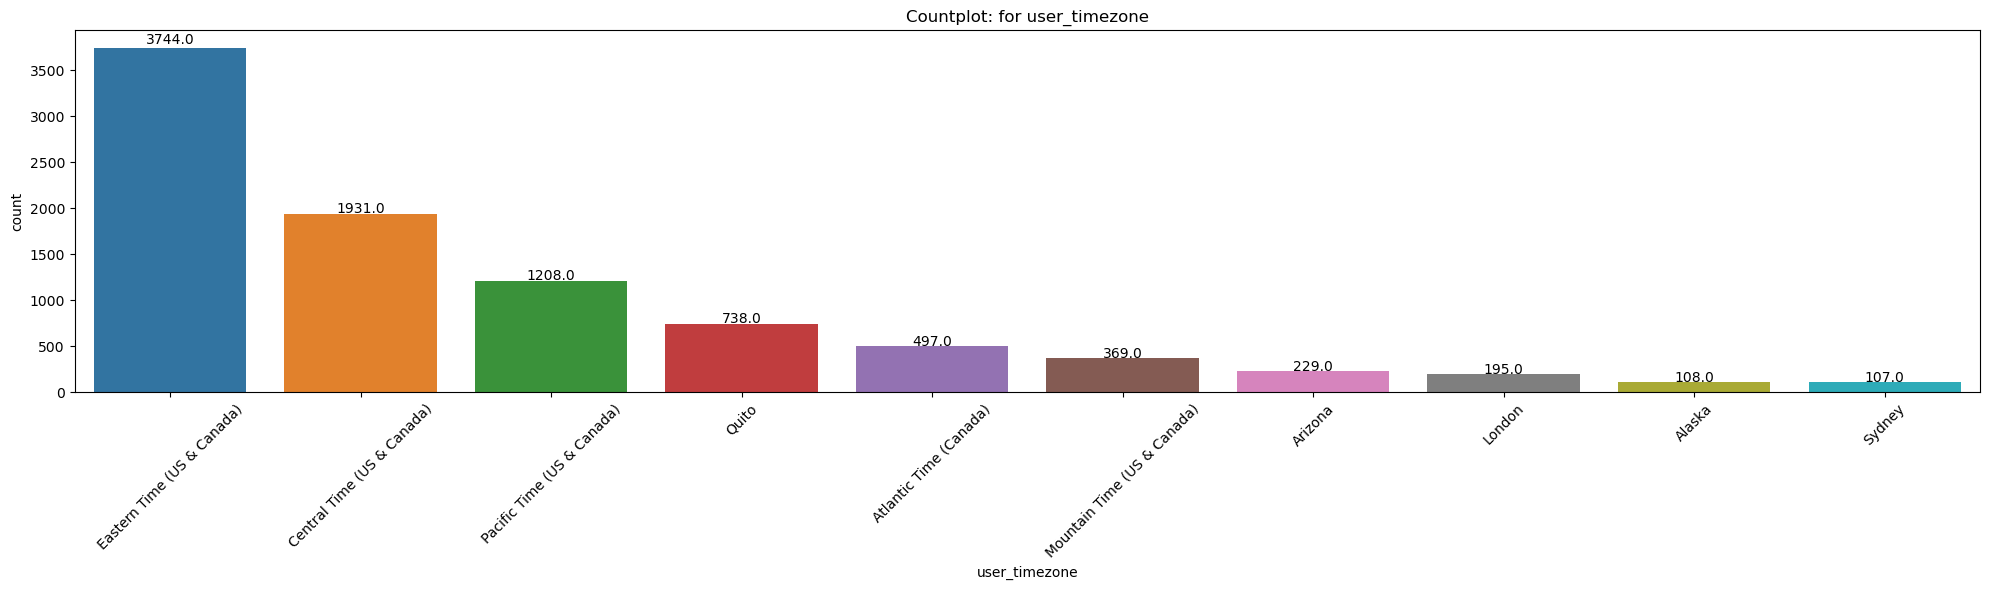

Eastern Time (US & Canada)     0.381263
Central Time (US & Canada)     0.196640
Pacific Time (US & Canada)     0.123014
Quito                          0.075153
Atlantic Time (Canada)         0.050611
Mountain Time (US & Canada)    0.037576
Arizona                        0.023320
London                         0.019857
Alaska                         0.010998
Sydney                         0.010896
Name: user_timezone, dtype: float64

In [51]:
top_timezone = data['user_timezone'].value_counts().head(10).index.tolist()

# Output a countplot of the user_timezone
output_pretty_countplot(data[data['user_timezone'].isin(top_timezone)], 'user_timezone',
                        order=data['user_timezone'].value_counts().head(10).index, figsize=(20, 6))
data['user_timezone'].value_counts(normalize=True).head(10)

#### Observations
- Of the top ten timezones the most common timezone for tweets is the Eastern Time zone with 38% followed by the Central time zone with 19.6%
- The top two timezones made up over 57% of the tweets.

- The timezone of the tweet location by timezone is biased towards US locations over overseas locations.

### <b> Bi-variate analysis

### Let's investigate airline with a hue of airline_sentiment

*What is the distribution of sentiments for each airline?*

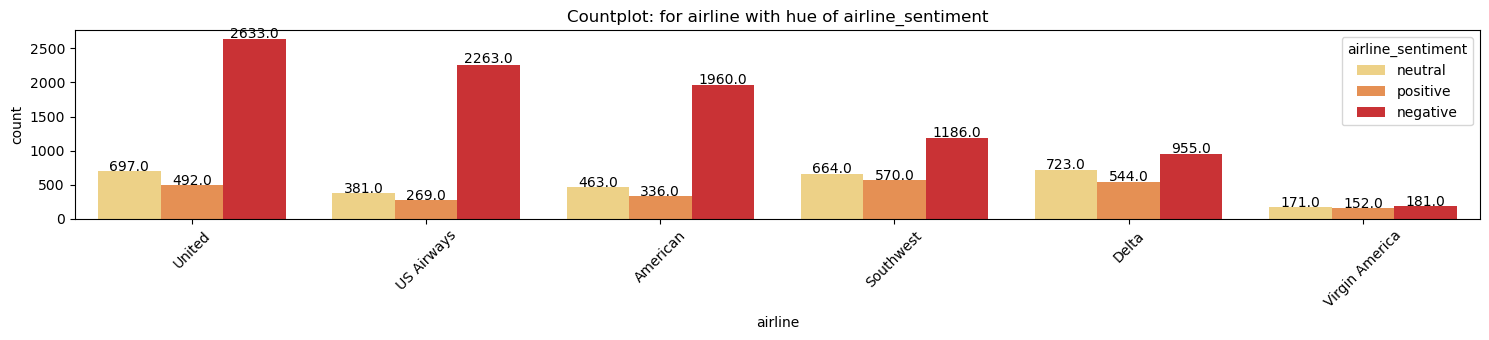

airline         airline_sentiment
American        positive             0.121783
                neutral              0.167814
                negative             0.710402
Delta           positive             0.244824
                neutral              0.325383
                negative             0.429793
Southwest       positive             0.235537
                neutral              0.274380
                negative             0.490083
US Airways      positive             0.092345
                neutral              0.130793
                negative             0.776862
United          positive             0.128728
                neutral              0.182365
                negative             0.688906
Virgin America  positive             0.301587
                neutral              0.339286
                negative             0.359127
Name: airline_sentiment, dtype: float64

In [52]:
# Output a countplot of the airline variable with a hue of airline_sentiment
output_pretty_countplot(data, 'airline', hue='airline_sentiment',
                        order=data['airline'].value_counts().index,
                        palette='YlOrRd')
data.groupby(['airline'])['airline_sentiment'].value_counts(normalize=True).sort_index(ascending=[True,False])

#### Observations
- United Airlines and US Airways have the highest number of negative tweets with 2633 and 2263 respectively.

- Southwest Airlines has the highest number of tweets with a positive sentiment (570) followed by Delta Airlines (544).
- Virgin America has the highest percentage of positive tweets with 30.1% followed by Soutwest Airlines with 23.5%

- We can see that US Airways has the highest percentage of negative sentiment with 77.6% followed by United Airlines with 68.8%
- The airline with the lowest negative sentiment percentage is Virgin America with 35.9%. In addition it appears that the distribution for this airline is roughly a third each for negative, neutral and positive sentiment.

### Let's investigate airline with a hue of the top negative reason for a poor rating

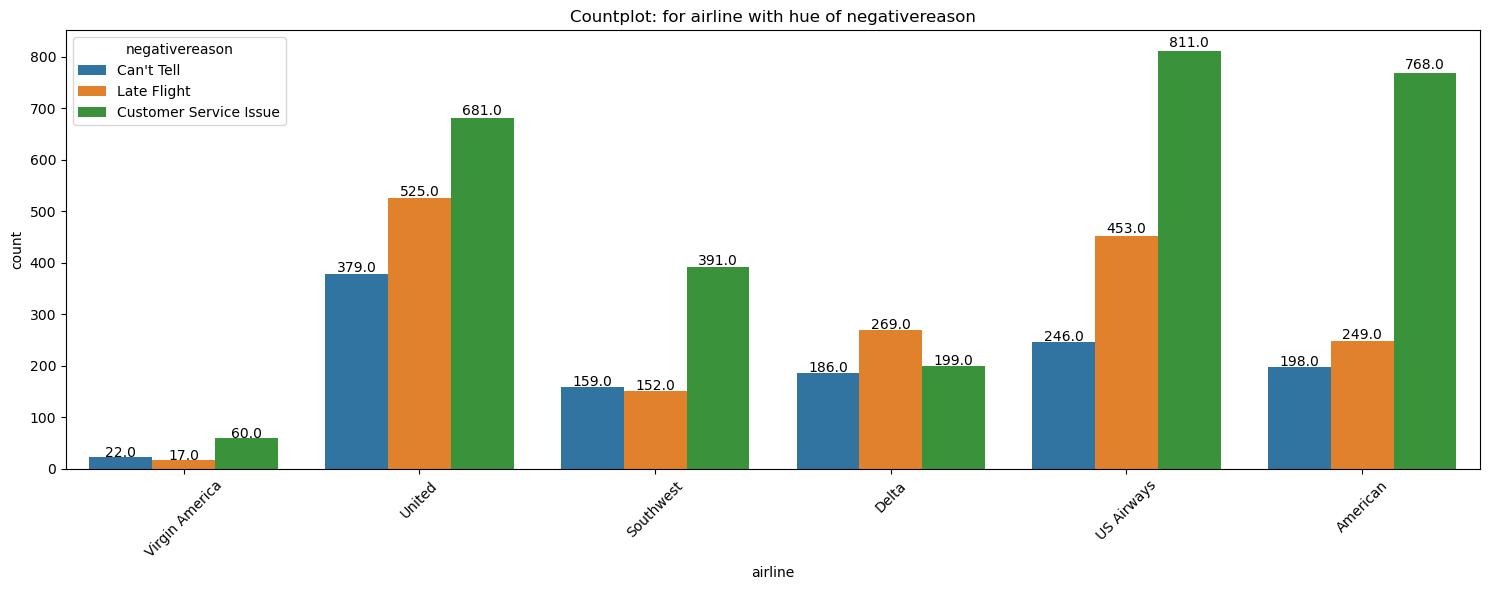

airline         negativereason        
Virgin America  Can't Tell                0.222222
                Customer Service Issue    0.606061
                Late Flight               0.171717
United          Can't Tell                0.239117
                Customer Service Issue    0.429653
                Late Flight               0.331230
US Airways      Can't Tell                0.162914
                Customer Service Issue    0.537086
                Late Flight               0.300000
Southwest       Can't Tell                0.226496
                Customer Service Issue    0.556980
                Late Flight               0.216524
Delta           Can't Tell                0.284404
                Customer Service Issue    0.304281
                Late Flight               0.411315
American        Can't Tell                0.162963
                Customer Service Issue    0.632099
                Late Flight               0.204938
Name: negativereason, dtype: float64

In [53]:
# Output a countplot of the negative_reasons by airline
top_reasons = ['Customer Service Issue', 'Late Flight', 'Can\'t Tell']
output_pretty_countplot(data[data['negativereason'].isin(top_reasons)], 'airline',hue='negativereason',
                        figsize=(15,6))
data[data['negativereason'].isin(top_reasons)].groupby(['airline'])['negativereason']\
            .value_counts(normalize=True).sort_index(ascending=[False, True])

#### Observations
- Of the top three negative reasons Customer Service was the top issue for each airline by percentage except for Delta. Delta's top negative reason was Late Flight. 

### Let's investigate user_timezone with a hue of airline_sentiment

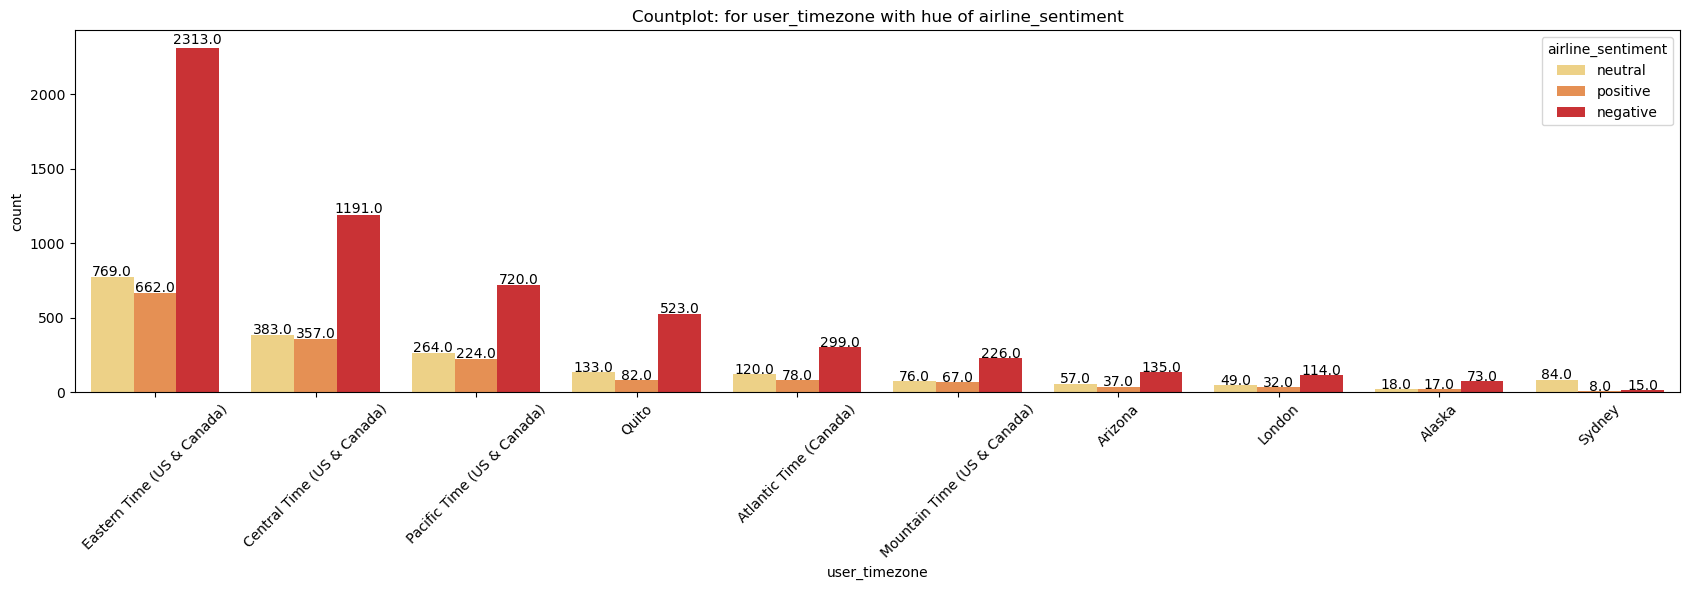

In [54]:
top_timezone = data['user_timezone'].value_counts().head(10).index.tolist()
# Output a countplot of the user_timezone with a hue of airline_sentiment
output_pretty_countplot(data[data['user_timezone'].isin(top_timezone)], 'user_timezone', hue='airline_sentiment',
                        palette='YlOrRd',
                        order=data['user_timezone'].value_counts().head(10).index, figsize=(17, 6))

#### Observations
- For the top 10 timezones by tweet the top three timezones are Eastern, Central and Pacific which have a negative tweet count of 2313, 1191 and 720 or percentagewise 61.7%, 61.6% and 59.6%. 
- The timezone with the lowest negative tweet percentage of 14% was Sydney also the lowest of the top 10 timezones.

### <b> Wordclouds showing sentiment

### Let's investigate negative sentiment

*How does a wordcloud appear for negative tweets?*

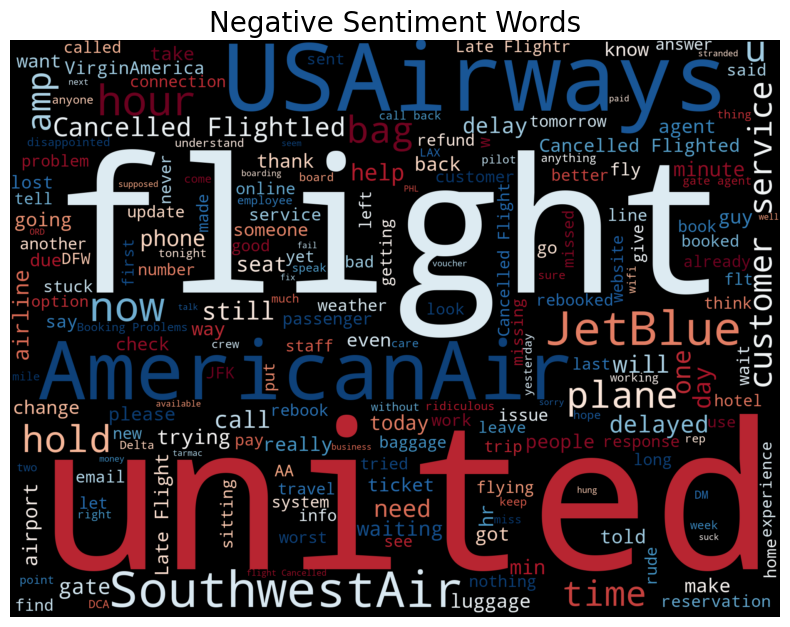

In [55]:
# Output a wordcloud for negative sentiment
output_wordcloud(data, title='Negative Sentiment Words', sentiment='negative')

#### Observations
- The top negative sentiment words are: united, flight, USAirways, AmericanAir.
- We can see customer service mentioned as one of the top words further down in the list as well as cancelled flight.
- This word order of importance for airlines coincide with the negative tweets plot shown above.

### Let's investigate positive sentiment

*How does a wordcloud appear for positive tweets?*

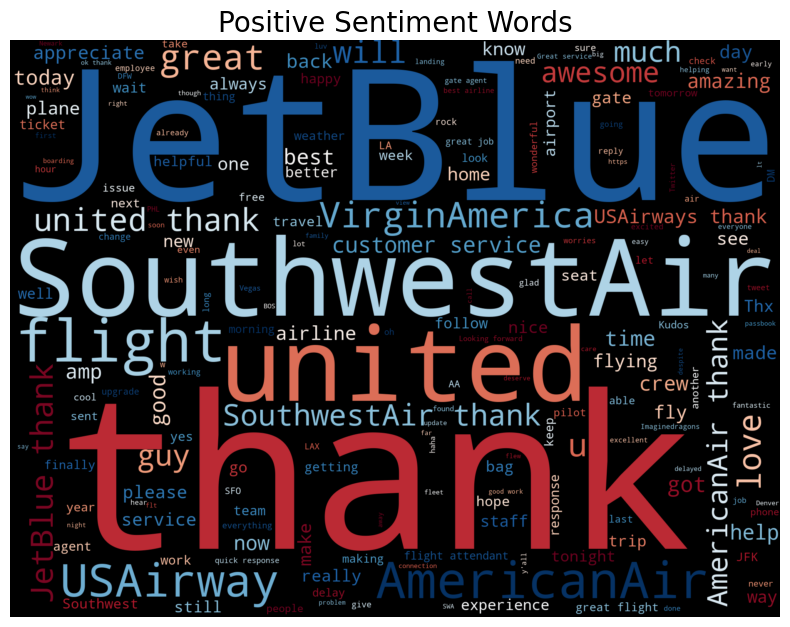

In [56]:
# Output a wordcloud for postive sentiment
output_wordcloud(data, title='Positive Sentiment Words', sentiment='positive')

#### Observations
- The top words with positive sentiment are thank, JetBlue, SouthwestAir and united.
- We can see several words further down in the list with a positive sentiment such as love, awesome and thank.
- Note that United was mentioned in top words for both positive and negative sentiment.
- What is interesting is that JetBlue is not in the analysis but appears in positive tweets. You can see from a list of tweets below that JetBlue is used for postive comparison to other airlines and in some instances JetBlue employees are mentioned 
for helping customers who are using a different airline.

In [57]:
display(data[(data['text'].str.contains('JetBlue')) & (data['airline_sentiment'] == 'positive')]['text'].head(10))

3963    @united :take note of this great example of @JetBlue actually making good for an extremely inconvenient situation. http://t.co/t3Gnk2N7LD
6746                         @JetBlue Yesterday on my way from EWR to FLL just after take-off. :)\n#wheelsup #JetBlueSoFly http://t.co/9xkiy0Kq2j
6759                                                                                                      @JetBlue thank you for the information.
6771                                                                                                                              @JetBlue great.
6772                              @JetBlue thanks great recap. I wouldn't have been able to sleep!  I was nervous the bad guy was getting away. 😉
6774                                                                                                  @JetBlue flight 117. proud to fly Jet Blue!
6775                                                                                                       @JetBlue awesome,

### Let's investigate neutral sentiment

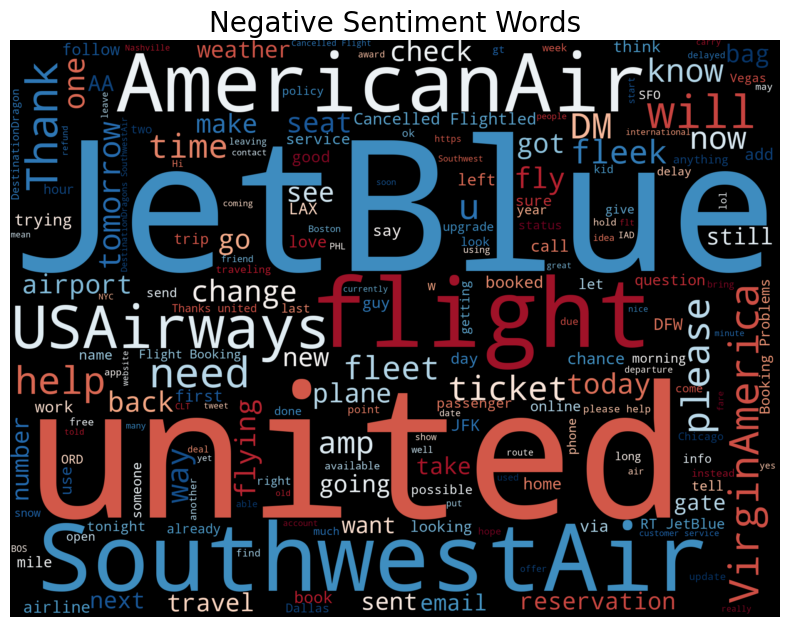

In [58]:
# Output a wordcloud for neutral sentiment
output_wordcloud(data, title='Negative Sentiment Words', sentiment='neutral')

#### Observations
- The top words found for neutral sentiment are JetBlue, united, flight and SouthwestAir.
- We can see several of the top words for neutral sentiment are similar to wordcloud for positive sentiment. 
- Note that United is mentioned in top words for both positive, negative and neutral sentiment while Southwest is a top word mentioned for both positive and neutral sentiment. 

### Data Preparation for modeling

- Take the relevant text and target column for sentiment analysis.

In [59]:
data_prepped = data[['airline_sentiment', 'text']].copy()

In [60]:
data_prepped.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Data Pre-processing:

Perform the below steps for data preprocessing.
- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Remove extra spaces
- Change to lowercase
- Remove punctuation
- Remove non-ascii characters
- Tokenization
- To remove Stopwords.
- Remove urls
- Lemmatized data

### Preprocess the text column

In [61]:
#### Before preprocessing
display(data_prepped['text'].head(10))

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

In [62]:
custom_list = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
processor = TextProcessor(custom_list=custom_list)

# Preprocess the data
data_prepped['text'] = processor.process(data_prepped['text'])

# Output head of processed tweets
display(data_prepped['text'].head(10))

0                                                                   virginamerica dhepburn say
1                                          virginamerica plus add commercials experience tacky
2                                     virginamerica not today must mean need take another trip
3    virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4                                                           virginamerica really big bad thing
5               virginamerica seriously would pay flight seat not play really bad thing fly va
6                              virginamerica yes nearly every time fly vx ear worm not go away
7                           virginamerica really miss prime opportunity men without hat parody
8                                                                    virginamerica well notbut
9                                                   virginamerica amaze arrive hour early good
Name: text, dtype: object

### Observations
- We can see that the data_prepped dataframe now has cleaned and lemmatized data.

## Model Building

In [63]:
# Stash the model training performance
training_results = {}

# Stash the model testing performance
testing_results = {}

# Dictionary of all the models
processed_models = {}

### Build the model based on countvectorizer and Random forest

- Intialize countvectorizer and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from Count vectorizer and random forest model


In [64]:
# Let's build a countvectorizer and fit_transform it
count_vec = CountVectorizer(max_features=2500)
data_features = count_vec.fit_transform(data_prepped['text']).toarray()

In [65]:
data_features.shape

(14640, 2500)

#### Observations
- The data_features has 14640 rows and 2500 columns

In [66]:
# Setup our X (independent variable) and Y (target variable)
X = data_features
y = data_prepped.airline_sentiment

In [67]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False,
                                                    random_state=seed)

# Check the shape of train, validation and test data
print('Training:{} {}'.format(X_train.shape,y_train.shape))
print('Test: {} {}'.format(X_test.shape,y_test.shape))

Training:(10980, 2500) (10980,)
Test: (3660, 2500) (3660,)


#### Observations
- X_train dataset has 10980 rows and 2500 columns while y_train has 10980 rows.
- X_test dataset has 3660 rows and 2500 columns while y_train has 3660 rows.

In [68]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#### Build a basic CountVectorizer Random Forest model with an optimized number of estimators

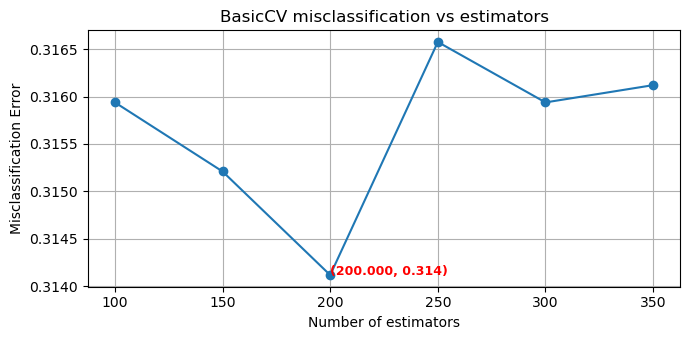

RandomForestClassifier(n_estimators=200, n_jobs=5, random_state=42)

In [69]:
## Build a basic RandomForestModel for CountVec
model1 = BasicRandomForest('BasicCV', X_train, y_train_encoded, X_test, y_test_encoded, 
                           ['negative', 'neutral', 'positive'])

#### Observations
- We see the optimal number of estimators is 200 with an error of .314.

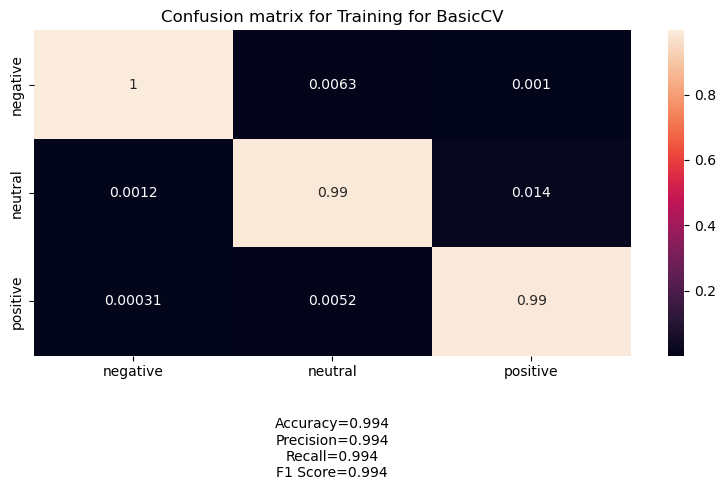

,precision,recall,f1-score,support
negative,0.998472,0.997252,0.997862,6551.000000
neutral,0.988474,0.986122,0.987297,2522.000000
positive,0.984904,0.992134,0.988506,1907.000000
accuracy,0.993807,0.993807,0.993807,0.993807
macro avg,0.990616,0.991836,0.991221,10980.000000
weighted avg,0.993819,0.993807,0.993810,10980.000000


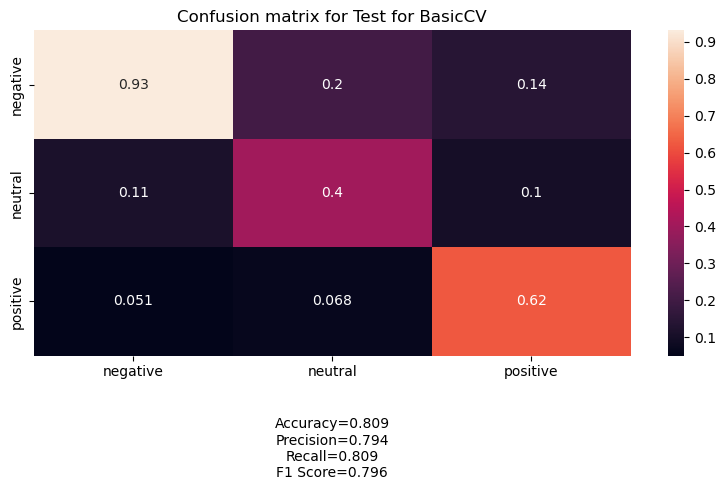

,precision,recall,f1-score,support
negative,0.849791,0.930339,0.888243,2627.000000
neutral,0.596401,0.402080,0.480331,577.000000
positive,0.718987,0.622807,0.667450,456.000000
accuracy,0.808743,0.808743,0.808743,0.808743
macro avg,0.721727,0.651742,0.678675,3660.000000
weighted avg,0.793547,0.808743,0.796427,3660.000000


In [70]:
model1.build_model()

#### Observations
- Training accuracy is 99.4% while testing accuracy is 80.9% which clearly shows the model is overfitting. 
- For the training dataset this model shows a True Positive rate for negative sentiment of 100%, neutral sentiment 99% and positive sentiment of 99%. 
- For the testing dataset this model shows a True Positive rate for negative sentiment of 93%, neutral sentiment 40% and positive sentiment of 62%. 
- The testing performance shows the model lost 59% on the True Positive rate for neutral sentiment.

#### Output a wordcloud with the top 20 features for this model

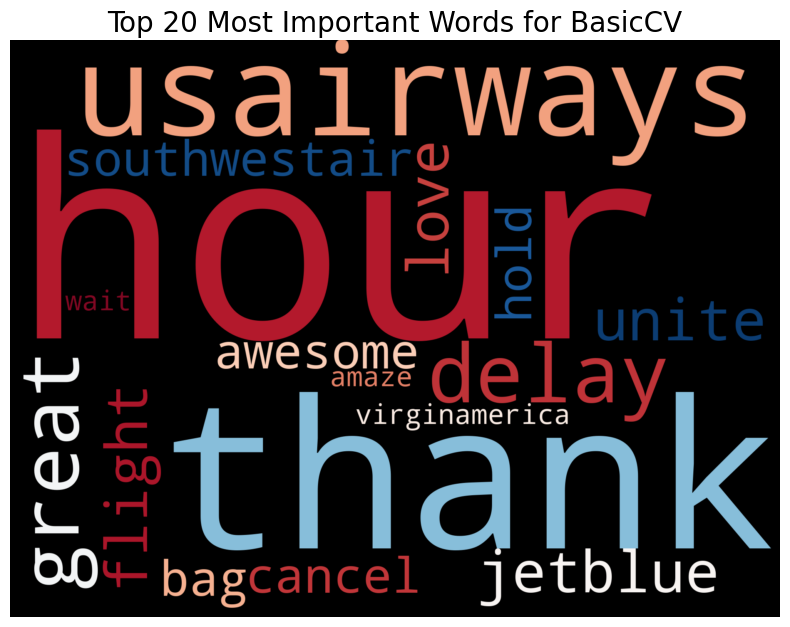

In [71]:
top_features = get_top_features(model1.model, all_features=count_vec.get_feature_names_out())
output_wordcloud(data_prepped, title='Top 20 Most Important Words for {}'.format(model1.model_name), 
                 top_features=top_features)

#### Observations
- The top features for this model are hour, thank, usairways and delay.

In [72]:
# Stash results
model_name = model1.model_name
testing_results[model_name] = model1.test_results.T
training_results[model_name] = model1.training_results.T
processed_models[model_name] = model1.model

#### Build a CountVectorizer Random Forest model with several optimized parameters including number of estimators

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.001, 'max_depth': 17, 'class_weight': {0: 0.558693329262708, 1: 1.451229183187946, 2: 1.9192448872574726}}


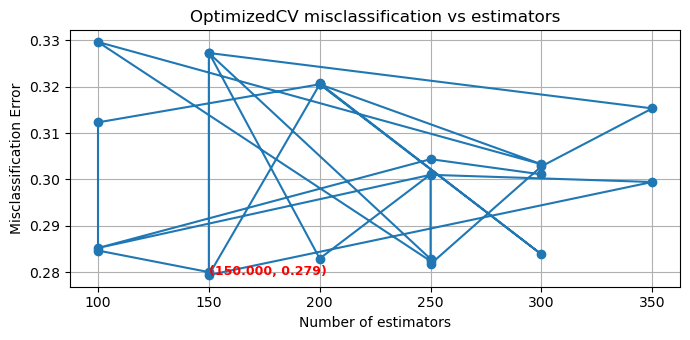

RandomForestClassifier(class_weight={0: 0.558693329262708, 1: 1.451229183187946,
                                     2: 1.9192448872574726},
                       max_depth=17, min_impurity_decrease=0.001,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, n_jobs=5, random_state=42)

In [73]:
## Build an optimized RandomForestModel for CountVec
model2 = OptimizedRandomForest('OptimizedCV', X_train, y_train_encoded, X_test, y_test_encoded, 
                               ['negative', 'neutral', 'positive'])

#### Observations
- We can see the circuitous route the randomized search took with n_estimators until it finally settled on 150 estimators with an error of .279 as optimal.
- Parameters for the optimized model are: 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.001, 'max_depth': 17. Note that this model also employs class weighting since the dataset is imbalanced.

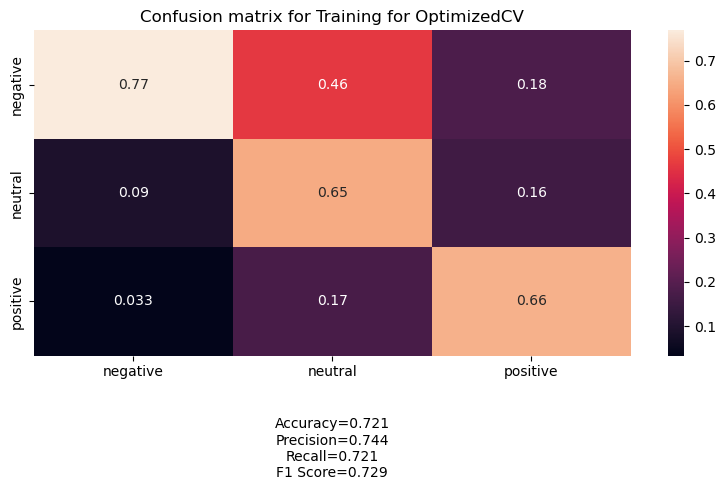

,precision,recall,f1-score,support
negative,0.861544,0.768432,0.812329,6551.000000
neutral,0.504020,0.646312,0.566366,2522.000000
positive,0.658960,0.657577,0.658268,1907.000000
accuracy,0.721129,0.721129,0.721129,0.721129
macro avg,0.674841,0.690774,0.678987,10980.000000
weighted avg,0.744239,0.721129,0.729076,10980.000000


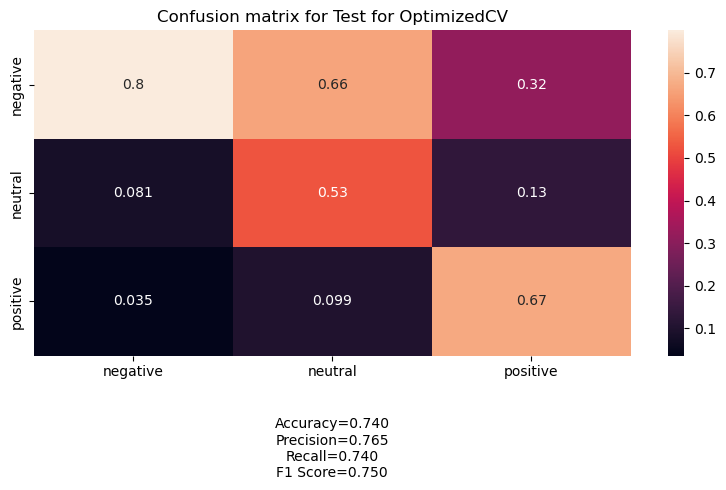

,precision,recall,f1-score,support
negative,0.872508,0.799772,0.834558,2627.000000
neutral,0.408356,0.525130,0.459439,577.000000
positive,0.600000,0.671053,0.633540,456.000000
accuracy,0.740437,0.740437,0.740437,0.740437
macro avg,0.626955,0.665318,0.642512,3660.000000
weighted avg,0.765383,0.740437,0.750376,3660.000000


In [74]:
model2.build_model()

#### Observations
- Training accuracy is 72.1% while testing accuracy is 74% which clearly shows the model is no longer overfitting.
- For the training dataset this model shows a True Positive rate for negative sentiment of 77%, neutral sentiment 65% and positive sentiment of 66%. 
- For the testing dataset this model shows a True Positive rate for negative sentiment of 80%, neutral sentiment 53% and positive sentiment of 67%. 
- The testing performance shows the model lost 12% on the True Positive rate for neutral sentiment.

- This model shows good predictive power and appears to be generalizable.

#### Output a wordcloud with the top 20 features for this model

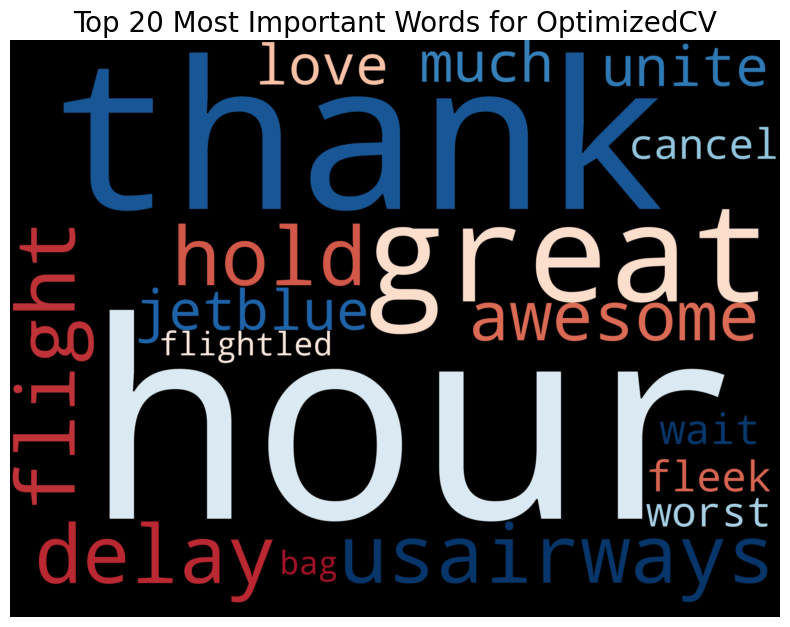

In [75]:
top_features = get_top_features(model2.model, all_features=count_vec.get_feature_names_out())
output_wordcloud(data_prepped, title='Top 20 Most Important Words for {}'.format(model2.model_name), 
                 top_features=top_features)

#### Observations
- The top features for this model are hour, thank and great and usairways.

In [76]:
# Stash results
model_name = model2.model_name
testing_results[model_name] = model2.test_results.T
training_results[model_name] = model2.training_results.T
processed_models[model_name] = model2.model

### Build the model based on Term Frequency(TF) - Inverse Document Frequency(IDF) and Random forest

- Intialize TFIDF and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal min_samples_split, min_samples_leaf, max_depth, min_impurity_decrease and n_estimators.
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
- Plot word cloud for top 20 important features obtained from TFIDF and random forest model



#### Build a basic TF-IDF Random Forest model with optimized number of estimators

In [77]:
# Let's build a TfIdfVectorizer
tf_idf_vect = TfidfVectorizer(max_features = 2500)
data_features = tf_idf_vect.fit_transform(data_prepped['text']).toarray()

In [78]:
data_features.shape

(14640, 2500)

#### Observations
- data_features has 14640 rows and 2500 columns.

In [79]:
# Setup our X (independent variable) and Y (target variable)
X = data_features
y = data_prepped.airline_sentiment

In [80]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=seed)

# Check the shape of train, validation and test data
print('Training:{} {}'.format(X_train.shape,y_train.shape))
print('Test: {} {}'.format(X_test.shape,y_test.shape))

Training:(10980, 2500) (10980,)
Test: (3660, 2500) (3660,)


#### Observations
- X_train dataset has 10980 rows and 2500 columns while y_train has 10980 rows.
- X_test dataset has 3660 rows and 2500 columns while y_train has 3660 rows.

In [81]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

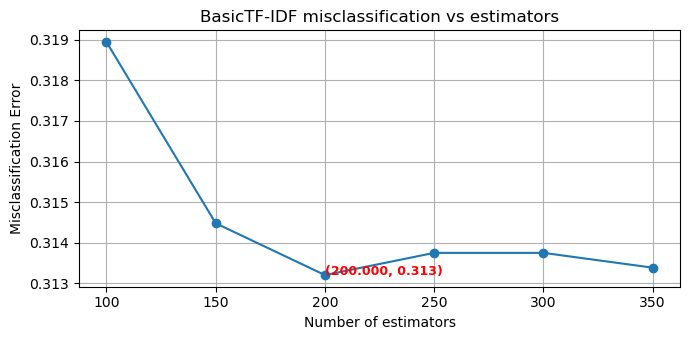

RandomForestClassifier(n_estimators=200, n_jobs=5, random_state=42)

In [82]:
## Build a basic RandomForestModel for TF-IDF
model3 = BasicRandomForest('BasicTF-IDF', X_train, y_train_encoded, X_test, y_test_encoded, ['negative', 'neutral', 'positive'])

#### Observations
- We see the optimal number of estimators is 200 with an error of .313.

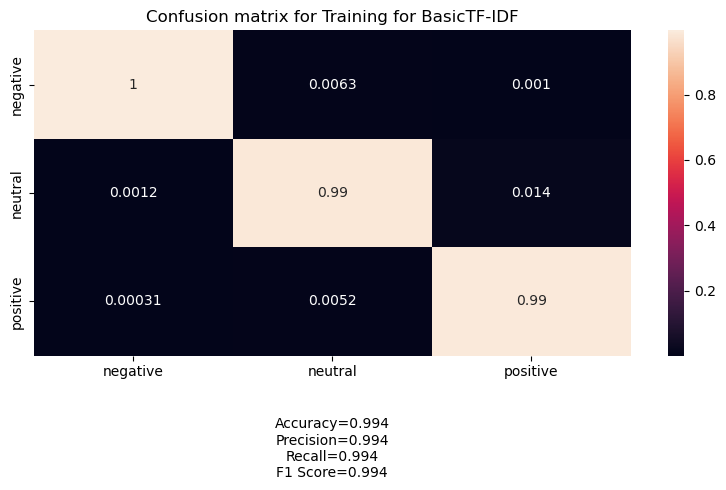

,precision,recall,f1-score,support
negative,0.998472,0.997252,0.997862,6551.000000
neutral,0.988474,0.986122,0.987297,2522.000000
positive,0.984904,0.992134,0.988506,1907.000000
accuracy,0.993807,0.993807,0.993807,0.993807
macro avg,0.990616,0.991836,0.991221,10980.000000
weighted avg,0.993819,0.993807,0.993810,10980.000000


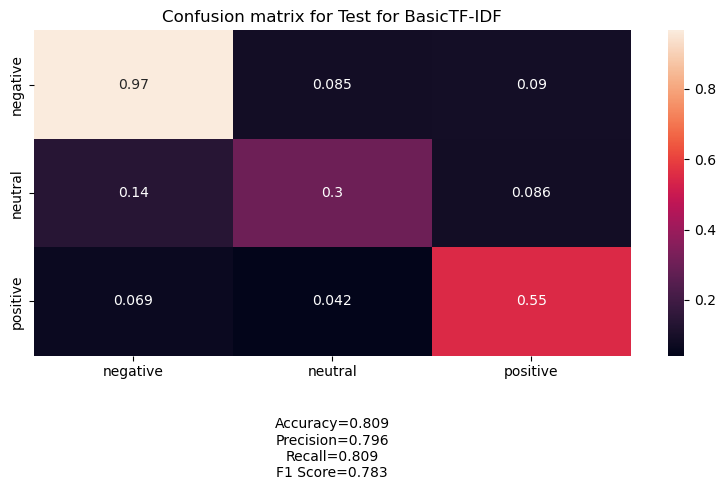

,precision,recall,f1-score,support
negative,0.822633,0.965740,0.888461,2627.000000
neutral,0.703252,0.299827,0.420413,577.000000
positive,0.757576,0.548246,0.636132,456.000000
accuracy,0.808743,0.808743,0.808743,0.808743
macro avg,0.761154,0.604604,0.648335,3660.000000
weighted avg,0.795707,0.808743,0.783235,3660.000000


In [83]:
model3.build_model()

#### Observations
- Training accuracy is 99.4% while testing accuracy is 80.9% which clearly shows the model is overfitting.
- For the training dataset this model shows a True Positive rate for negative sentiment of 100%, neutral sentiment 99% and positive sentiment of 99%. 
- For the testing dataset this model shows a True Positive rate for negative sentiment of 97%, neutral sentiment 30% and positive sentiment of 55%. 

- The testing performance shows the model lost 69% on the True Positive rate for neutral sentiment.

#### Output a wordcloud with the top 20 features for this model

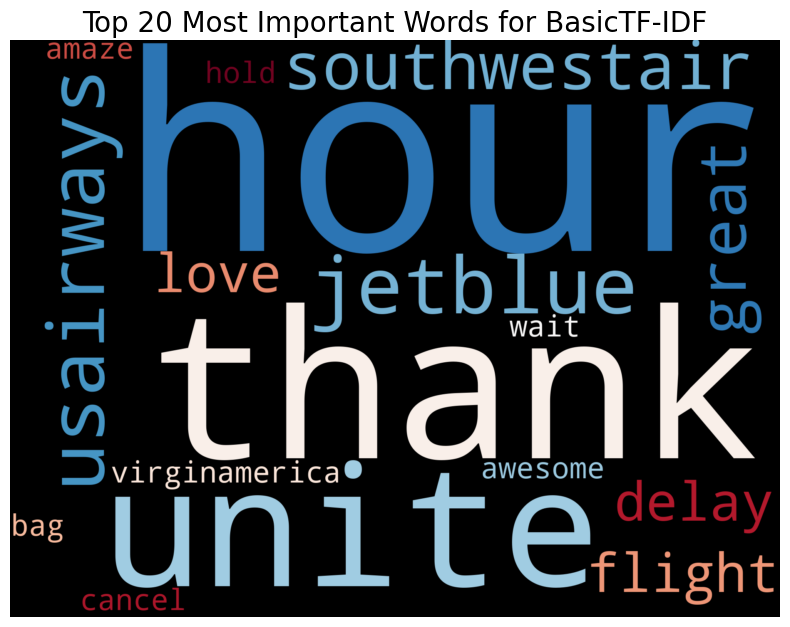

In [111]:
top_features = get_top_features(model3.model, all_features=tf_idf_vect.get_feature_names_out())
output_wordcloud(data_prepped, title='Top 20 Most Important Words for {}'.format(model3.model_name), 
                 top_features=top_features)

#### Observations
- Top features for this model are hour, thank, unite and jetblue.
- unite is likely the lemmatized root for united from united airlines.

In [85]:
# Stash results
model_name = model3.model_name
testing_results[model_name] = model3.test_results.T
training_results[model_name] = model3.training_results.T
processed_models[model_name] = model3.model

#### Build a TF-IDF Random Forest model with several optimized parameters including number of estimators

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.001, 'max_depth': 31, 'class_weight': {0: 0.558693329262708, 1: 1.451229183187946, 2: 1.9192448872574726}}


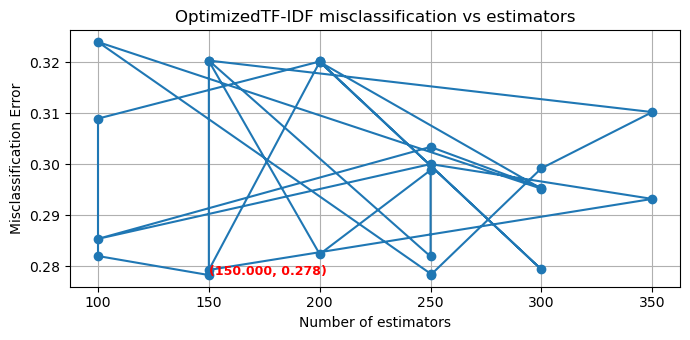

RandomForestClassifier(class_weight={0: 0.558693329262708, 1: 1.451229183187946,
                                     2: 1.9192448872574726},
                       max_depth=31, min_impurity_decrease=0.001,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150, n_jobs=5, random_state=42)

In [86]:
## Build a optimized RandomForestModel for TF-IDF
model4 = OptimizedRandomForest('OptimizedTF-IDF', X_train, y_train_encoded, X_test, y_test_encoded, 
                               ['negative', 'neutral', 'positive'])

#### Observations
- We can see the circuitous route the randomized search took with n_estimators until it finally settled on 150 estimators with an error of .278 as optimal.
- Parameters for the optimized model are: 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.001, 'max_depth': 31. Note that this model also employs class weighting since the dataset is imbalanced.

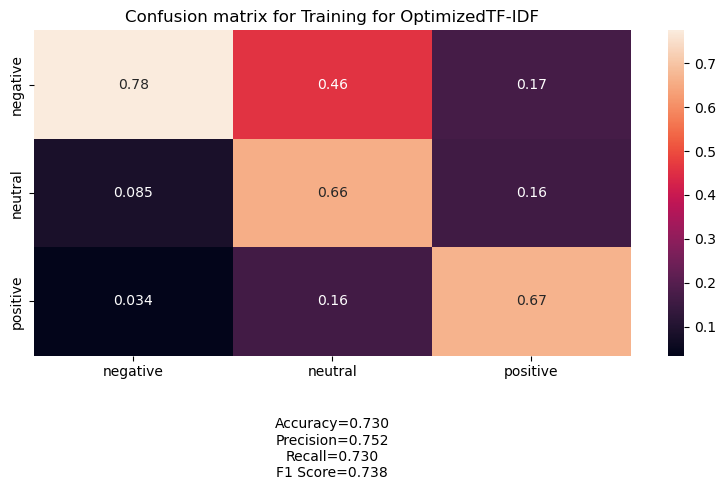

,precision,recall,f1-score,support
negative,0.867464,0.775301,0.818797,6551.000000
neutral,0.514870,0.659001,0.578087,2522.000000
positive,0.671587,0.668065,0.669821,1907.000000
accuracy,0.729964,0.729964,0.729964,0.729964
macro avg,0.684640,0.700789,0.688902,10980.000000
weighted avg,0.752457,0.729964,0.737634,10980.000000


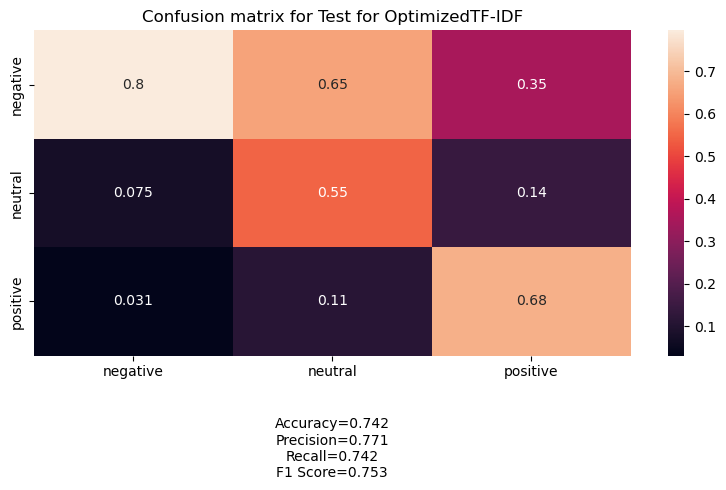

,precision,recall,f1-score,support
negative,0.882651,0.795965,0.837070,2627.000000
neutral,0.415567,0.545927,0.471910,577.000000
positive,0.579737,0.677632,0.624874,456.000000
accuracy,0.741803,0.741803,0.741803,0.741803
macro avg,0.625985,0.673175,0.644618,3660.000000
weighted avg,0.771275,0.741803,0.753065,3660.000000


In [87]:
model4.build_model()

#### Observations
- Training accuracy is 73.1% while testing accuracy is 74.2% which clearly shows the model is no longer overfitting.
- For the training dataset this model shows a True Positive rate for negative sentiment of 78%, neutral sentiment 66% and positive sentiment of 67%. 
- For the testing dataset this model shows a True Positive rate for negative sentiment of 80%, neutral sentiment 55% and positive sentiment of 68%. 
- The testing performance shows the model lost 11% on the True Positive rate for neutral sentiment.

- This model shows good predictive power and appears to be generalizable and is a slight improvement from the CountVec optimized model.

#### Output a wordcloud with the top 20 features for this model

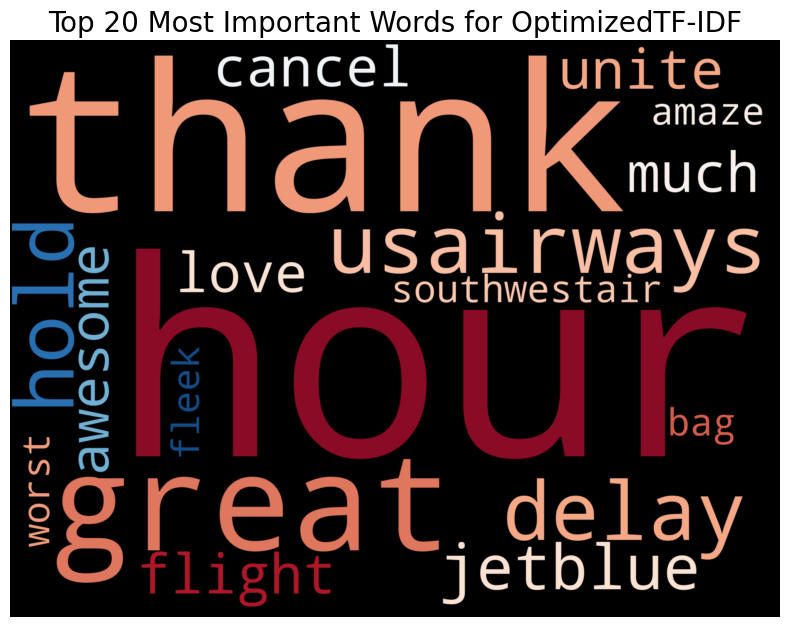

In [88]:
top_features = get_top_features(model4.model, all_features=tf_idf_vect.get_feature_names_out())
output_wordcloud(data_prepped, title='Top 20 Most Important Words for {}'.format(model4.model_name), top_features=top_features)

#### Observations
- The top features are hour, thank, great and usairways for this model.

In [89]:
# Stash results
model_name = model4.model_name
testing_results[model_name] = model4.test_results.T
training_results[model_name] = model4.training_results.T
processed_models[model_name] = model4.model

### Build the model based using LSTM

#### Tokenize and convert the review to vectors

In [90]:
# set the seed for reproducibility
set_seed(seed)

# Creating the tokenizer with vocab size
vocab_size = 2500
embedding_dimension = 32
tokenizer = Tokenizer(num_words = vocab_size, split = ' ')

tokenizer.fit_on_texts(data_prepped['text'].values)

# converting text to sequences
X = tokenizer.texts_to_sequences(data_prepped['text'].values)

# Padding the sequences
X = pad_sequences(X)

X.shape

(14640, 22)

#### Observations
- The data features sequences have 14640 rows and 22 columns.

#### Build the model

In [91]:
model5 = Sequential()

# Add the embedding layer
model5.add(Embedding(vocab_size, output_dim=embedding_dimension, input_length = X.shape[1]))

model5.add(SpatialDropout1D(0.7))

# Add an LSTM layer with dropout and recurrent dropout
model5.add(LSTM(16, dropout = 0.6, recurrent_dropout = 0.6))
model5.add(Dropout(0.4))

num_classes = len(data_prepped.airline_sentiment.unique())
model5.add(Dense(num_classes, activation = 'softmax'))

# compile the model
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [92]:
display(model5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 32)            80000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 22, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 83,187
Trainable params: 83,187
Non-trainable params: 0
____________________________________________________

None

#### Observations
- The model has 83,187 total parameters. 

#### Split the data

In [93]:
# creating the target feature
y = data_prepped.airline_sentiment

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed,
                                                                  stratify=y_train)

# Check the shape of train, validation and test data
print('Training:{} {}'.format(X_train.shape,y_train.shape))
print('Validation:{} {}'.format(X_val.shape,y_val.shape))
print('Test: {} {}'.format(X_test.shape,y_test.shape))

Training:(9223, 22) (9223,)
Validation:(1025, 22) (1025,)
Test: (4392, 22) (4392,)


#### Observations
- X_train has 9223 rows and 22 columns while y_train has 9223 rows.
- X_val has 1025 rows and 22 columns while y_val has 1025 rows.
- X_train has 4392 rows and 22 columns while y_train has 4392 rows.

In [94]:
# Encode target variable using LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform(y_train)
y_val_encoded = label_binarizer.transform(y_val)
y_test_encoded = label_binarizer.transform(y_test)

# Let's get the list of classes from post LabelBinarizer encoding
unique_encoded = np.flip(np.unique(y_train_encoded, axis=0), axis=0)
categories_decoded = label_binarizer.inverse_transform(unique_encoded)
categories_decoded

array(['negative', 'neutral', 'positive'], dtype='<U8')

#### Calculate class weights

In [95]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=categories_decoded,
                                                  y=y_train.values.reshape(-1))
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5317075982935547, 1: 1.5749658469945356, 2: 2.064696664428028}

### Fit the model

In [96]:
# Train the model on the training data
epochs = 30
batch_size = 32
callbacks = get_callbacks('LSTM', early_stopping_patience=8)
history = model5.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_encoded),
                    callbacks=callbacks, class_weight=d_class_weights)

Epoch 1/30
289/289 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.5344
Epoch 1: val_loss improved from inf to 0.85824, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 8s 19ms/step - loss: 1.0322 - accuracy: 0.5344 - val_loss: 0.8582 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 2/30
288/289 [============================>.] - ETA: 0s - loss: 0.9003 - accuracy: 0.6465
Epoch 2: val_loss improved from 0.85824 to 0.71706, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 17ms/step - loss: 0.9001 - accuracy: 0.6465 - val_loss: 0.7171 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 3/30
287/289 [============================>.] - ETA: 0s - loss: 0.8201 - accuracy: 0.6865
Epoch 3: val_loss improved from 0.71706 to 0.63775, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 16ms/step - loss: 0.8211 - accuracy: 0.6861 - val_loss: 0.6377 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 4/30
285/289 [============================>.] - ETA: 0s - loss: 0.7609 - accuracy: 0.7041
Epoch 4: val_loss did not improve from 0.63775
289/289 [==============================] - 3s 10ms/step - loss: 0.7615 - accuracy: 0.7035 - val_loss: 0.6605 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 5/30
288/289 [============================>.] - ETA: 0s - loss: 0.7325 - accuracy: 0.7177
Epoch 5: val_loss improved from 0.63775 to 0.58612, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 17ms/step - loss: 0.7320 - accuracy: 0.7179 - val_loss: 0.5861 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 6/30
288/289 [============================>.] - ETA: 0s - loss: 0.7083 - accuracy: 0.7225
Epoch 6: val_loss did not improve from 0.58612
289/289 [==============================] - 3s 10ms/step - loss: 0.7084 - accuracy: 0.7224 - val_loss: 0.5866 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 7/30
284/289 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.7353
Epoch 7: val_loss did not improve from 0.58612

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
289/289 [==============================] - 3s 10ms/step - loss: 0.6842 - accuracy: 0.7346 - val_loss: 0.5868 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 8/30
288/289 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.7463
Epoch 8: val_loss did not improve from 0.58612
289/289 [==============================] - 3s 10ms/step - 

INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 18ms/step - loss: 0.6581 - accuracy: 0.7427 - val_loss: 0.5852 - val_accuracy: 0.7610 - lr: 1.0000e-04
Epoch 10/30
288/289 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.7439
Epoch 10: val_loss did not improve from 0.58515
289/289 [==============================] - 3s 12ms/step - loss: 0.6572 - accuracy: 0.7440 - val_loss: 0.5875 - val_accuracy: 0.7590 - lr: 1.0000e-04
Epoch 11/30
286/289 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.7469
Epoch 11: val_loss improved from 0.58515 to 0.58382, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 19ms/step - loss: 0.6613 - accuracy: 0.7472 - val_loss: 0.5838 - val_accuracy: 0.7620 - lr: 1.0000e-04
Epoch 12/30
289/289 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.7462
Epoch 12: val_loss improved from 0.58382 to 0.57463, saving model to airline_LSTM


INFO:tensorflow:Assets written to: airline_LSTM\assets


INFO:tensorflow:Assets written to: airline_LSTM\assets


289/289 [==============================] - 5s 19ms/step - loss: 0.6527 - accuracy: 0.7462 - val_loss: 0.5746 - val_accuracy: 0.7649 - lr: 1.0000e-04
Epoch 13/30
287/289 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.7515
Epoch 13: val_loss did not improve from 0.57463
289/289 [==============================] - 3s 10ms/step - loss: 0.6442 - accuracy: 0.7516 - val_loss: 0.5804 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 13: early stopping


In [97]:
loaded_model = tf.keras.models.load_model('airline_{}'.format('LSTM'))

In [98]:
loaded_model.evaluate(X_test,y_test_encoded)

138/138 [==============================] - 1s 2ms/step - loss: 0.5806 - accuracy: 0.7814


[0.5805860757827759, 0.7814207673072815]

#### Observations
- The accuracy for the test dataset is .7814

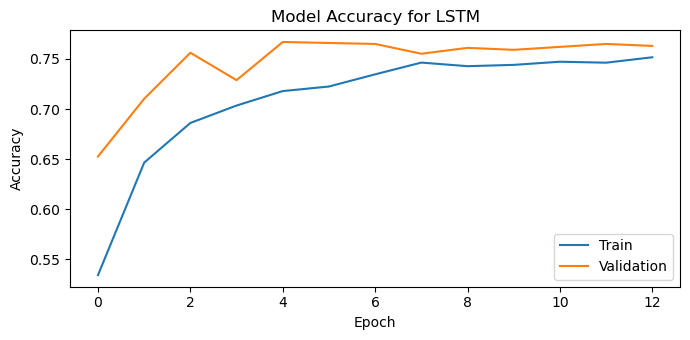

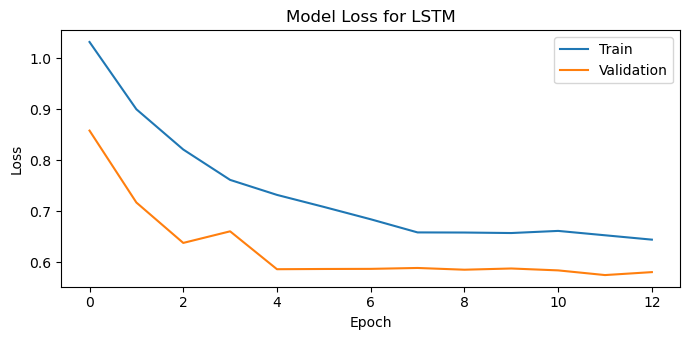

In [99]:
plot_loss_accuracy('LSTM', history)

#### Observations
- The loss and accuracy curves show that the training and validation datasets track very well.
- The model shows good predictive power and seems to be generalizable.

289/289 [==============================] - 1s 2ms/step


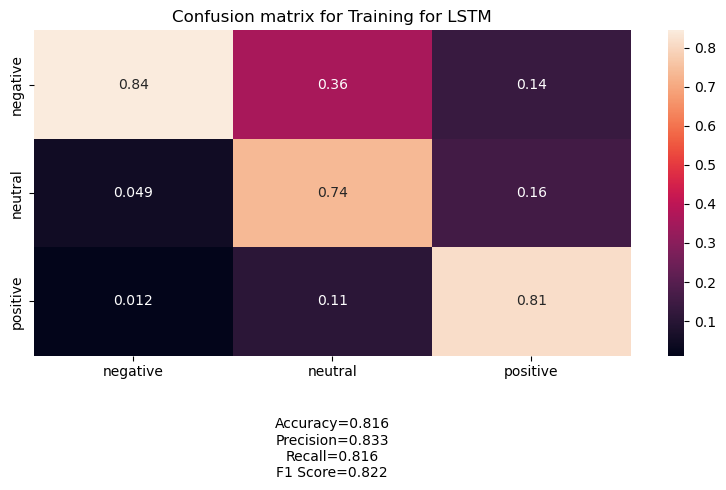

,precision,recall,f1-score,support
negative,0.932900,0.843999,0.886225,5782.000000
neutral,0.612367,0.735656,0.668373,1952.000000
positive,0.736491,0.814641,0.773597,1489.000000
accuracy,0.816329,0.816329,0.816329,0.816329
macro avg,0.760586,0.798098,0.776065,9223.000000
weighted avg,0.833352,0.816329,0.821935,9223.000000


In [100]:
lstm_training_results, y_pred_training = output_results(loaded_model, X_train, y_train_encoded, categories_decoded, title='Training for {}'.format('LSTM'), figsize=(8,5), binarized=True)

#### Observations
- Accuracy for this model for training is 81.6%.
- This model shows a True Positive rate for negative sentiment of 84%, neutral sentiment 74% and positive sentiment of 81%.

 17/138 [==>...........................] - ETA: 0s138/138 [==============================] - 0s 2ms/step


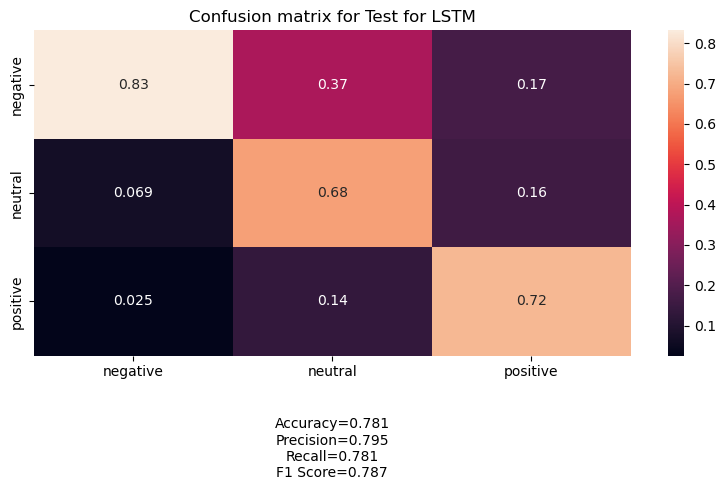

,precision,recall,f1-score,support
negative,0.898079,0.832183,0.863876,2753.000000
neutral,0.573516,0.675269,0.620247,930.000000
positive,0.687668,0.723554,0.705155,709.000000
accuracy,0.781421,0.781421,0.781421,0.781421
macro avg,0.719754,0.743669,0.729759,4392.000000
weighted avg,0.795387,0.781421,0.786666,4392.000000


In [101]:
lstm_testing_results, y_pred_testing = output_results(loaded_model, X_test, y_test_encoded, categories_decoded, title='Test for {}'.format("LSTM"), figsize=(8,5), binarized=True)

#### Observations
- Accuracy for this model for testing is 78.1% which is fairly close to the training accuracy of 81.6% which shows the model generalizability.
- This model shows a True Positive rate for negative sentiment of 83%, neutral sentiment 68% and positive sentiment of 72%. 
- With the testing dataset both the neutral and positive sentiment True Positive rate declined from the training dataset.
- This model achieved the highest testing accuracy of any model.

In [102]:
# Stash results
model_name = 'LSTM'
testing_results[model_name] = lstm_testing_results.T
training_results[model_name] = lstm_training_results.copy().T
processed_models[model_name] = loaded_model

## Final Results

In [103]:
# training performance comparison
models_training_comp_df = get_performance_results(training_results, 'Training')
models_training_comp_df

,BasicCV,OptimizedCV,BasicTF-IDF,OptimizedTF-IDF,LSTM
Accuracy,0.993807,0.721129,0.993807,0.729964,0.816329
Recall,0.993807,0.721129,0.993807,0.729964,0.816329
Precision,0.993819,0.744239,0.993819,0.752457,0.833352
F1,0.993810,0.729076,0.993810,0.737634,0.821935


In [104]:
# training performance comparison
models_testing_comp_df = get_performance_results(testing_results, 'Testing')
models_testing_comp_df

,BasicCV,OptimizedCV,BasicTF-IDF,OptimizedTF-IDF,LSTM
Accuracy,0.808743,0.740437,0.808743,0.741803,0.781421
Recall,0.808743,0.740437,0.808743,0.741803,0.781421
Precision,0.793547,0.765383,0.795707,0.771275,0.795387
F1,0.796427,0.750376,0.783235,0.753065,0.786666


## Final Model

- Based on the results I recommend the LSTM model which achieved 81.6% accuracy on the training dataset and 78.1% on the testing dataset.

## Actionable Insights and Recommendations
* The LSTM model achieved 81.6 accuracy on the training dataset and 78.1% on the testing dataset which shows strong predictive power and model generalizability.
* This model has a True Positive rate for negative sentiment of 83%, neutral sentiment 68% and positive sentiment of 72% for the testing dataset. 

* The top three airlines by tweet was United, USAirways and American with 26.1%, 19.8% and 18.8% of all tweets respectively.
* 62.6% of the airline_sentiment is negative while only 16.1% is positive showing imbalanced data which was dealt with in some of the models with class weighting.
* Customer Service Issues was by far the top negative reason given by customers (31.7%) as well as gold customers (37.5%). This is something the airlines control and could make a significant impact on reducing negative sentiment. Some potential options:
> - Open and frequent communication with customers.
> - Encourage and motivate employees to treat customers in a professional and courteous manner.
> - Optimize processes such as boarding, bag checkin etc.
> - Provide impacted customers with discounts and vouchers.
- JetBlue was not one of the airlines in the analysis but was mentioned frequently as an airline others could emulate for their customer service. Below are some example tweets:
> - @united :take note of this great example of @JetBlue actually making good for an extremely inconvenient situation. http://t.co/t3Gnk2N7LD
> - @JetBlue Yesterday on my w@JetBlue thank you for the information.
> - @JetBlue great.
> - @JetBlue Thanks for the quick reply! Just wanted to make sure it wasn't just my account :)
> - JetBlue should be explored to find out why customers seem to have a positive outlook towards them.

* The top negative sentiment words are: united, flight, USAirways, AmericanAir.
* The top words with positive sentiment are thank, JetBlue, SouthwestAir and united.

### Data Insights
* The top three tweet locations are Boston, New York and Washington DC which make up over 4.5% of the tweet.
* The most common timezone for tweets is the Eastern Time zone with 38% followed by the Central time zone with 19.6%
* Of the top three negative reasons Customer Service was the top issue for each airline by percentage except for Delta. Delta's top negative reason was Late Flight. 
* United Airlines and US Airways have the highest number of negative tweets with 2633 and 2263 respectively.
* US Airways has the highest percentage of negative sentiment with 77.6% followed by United Airlines with 68%
* Southwest Airlines has the highest number of tweets with a positive sentiment (570) followed by Delta Airlines (544).

* Of the top three negative reasons Customer Service was the top issue for each airline by percentage except for Delta. Delta's top negative reason was Late Flight. 

#### Further analysis that can be done:
* In this dataset the source timezone for tweets favors US locations. In a subsequent analysis more offshore locations could be acquired to expand the coverage and appliocability of the model.
* Rerun the analysis with more offshore data and several weeks or months tweet data in order to make the modeling results even more predictive and robust.
- Finally the recommended analysis above should include JetBlue as an airline in order to glean further information about how customers truly perceive that airline compared to its competitors.